<center>
    <img src="Jupyter/ETSIAE2.png" width="200" alt="cognitiveclass.ai logo"  align="right" style="margin:auto"/>
    <img src="Jupyter/gam3.png" width="300" alt="cognitiveclass.ai logo" align="center" style="margin:auto"/>

</center>

# Applying Artificial Neural Networks to Predict UAS Collisions

UAS trajectories taken from the SESAR DACUS Project.
This data has been analysed with a Python code to identify pairs of UAS flying simultaneously with a minimum distance among them lower than 1000 m. For these pairs, the position of each aircraft and the distance has been calculated for the time of minimum distante (t) minus [0,1,2,3,4,5,10,15,20,25,30,40,50...] seconds

## Objectives

Use this dataset to:

-   Implement ANN to classify data
-   Create a model, train,test and use the model


## <span style="color:red">Section 1: Importing and analysing the Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
from sklearn import preprocessing
%matplotlib inline
import geopandas 
from shapely import geometry
#import folium

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### <span style="color:blue">The original UAS trajectories dataframe lists UAS positions at different times (waypoint). The trajectory of a single UAS is formed by several rows in the dataframe.

### Each row indicates the Drone_ID (name), the Drone_number, the Category of the UAS and the 4D coordinates (Lat, Lon, Alt, Time) at this waypoint

In [3]:
f='C:/Users/victor.gordo\OneDrive - Ingeniería y Economía del Transporte S.A/Documents/Trabajo/python/DOCTORADO/Madrid_Traffic_samples/MadridV9a_SPD_NR_by_Time.csv'
dataframe_drones = pd.read_csv(f)
dataframe_drones.head(10)

,Drone_ID,Drone_ID_number,Lat,Lon,Altitude (m),seconds_of_day,Datetime,Category
0,SURTRAF1__001_1,3739,40.479411,-3.675713,0.0,0.0,00:00:00,0
1,SURTRAF1__001_1,3739,40.479411,-3.675713,0.0,0.0,00:00:00,0
2,SURTRAF1__001_1,3739,40.479411,-3.675713,0.0,0.0,00:00:00,0
3,SURTRAF10__001_1,3835,40.389812,-3.713061,0.0,0.0,00:00:00,0
4,SURTRAF10__001_1,3835,40.389812,-3.713061,0.0,0.0,00:00:00,0
5,SURTRAF10__001_1,3835,40.389812,-3.713061,0.0,0.0,00:00:00,0
6,SURTRAF11__001_1,3931,40.416370,-3.651199,0.0,0.0,00:00:00,0
7,SURTRAF11__001_1,3931,40.416370,-3.651199,0.0,0.0,00:00:00,0
8,SURTRAF11__001_1,3931,40.416370,-3.651199,0.0,0.0,00:00:00,0
9,SURTRAF12__001_1,4027,40.449850,-3.649395,0.0,0.0,00:00:00,0


In [201]:
dataframe_drones.shape

(257702, 8)

In [202]:
    dataframe_drones_G = dataframe_drones.copy()
    #dataframe_drones.drop(['Drone_ID_number'], axis =1, inplace=True)
    dataframe_drones.columns = ['Drone_ID', 'Drone_ID_number', 'Lat','Long','H_geo','Seconds_of_day','Datetime','Category']
    dataframe_drones.sort_values(by=['Drone_ID','Datetime'],inplace=True)
    gdf_drones = geopandas.GeoDataFrame(
        dataframe_drones, geometry=geopandas.points_from_xy(dataframe_drones.Long, dataframe_drones.Lat))
    gdf_drones.head()

,Drone_ID,Drone_ID_number,Lat,Long,H_geo,Seconds_of_day,Datetime,Category,geometry
73302,Alcala_1,0,40.42019,-3.6888,0.0,36669.63,10:11:10,1,POINT (-3.68880 40.42019)
73303,Alcala_1,0,40.42019,-3.6888,0.0,36669.63,10:11:10,1,POINT (-3.68880 40.42019)
73304,Alcala_1,0,40.42019,-3.6888,0.0,36669.63,10:11:10,1,POINT (-3.68880 40.42019)
73675,Alcala_1,0,40.42019,-3.6888,0.0,36768.63,10:12:49,1,POINT (-3.68880 40.42019)
73676,Alcala_1,0,40.42019,-3.6888,0.0,36768.63,10:12:49,1,POINT (-3.68880 40.42019)


In [203]:
gdf_drones.shape

(257702, 9)

In [204]:
    #Initialize drone landings and takeoffs
    TO_LND_nom = pd.DataFrame()
    TO_LND_nom['Drone_ID'] = dataframe_drones['Drone_ID'].unique()
    TO_LND_nom.drop_duplicates(subset=['Drone_ID'],inplace = True)
    TO_df= dataframe_drones.sort_values('Seconds_of_day').groupby('Drone_ID').first()
    TO_LND_nom['TO_datetime'] = TO_df['Datetime'].to_numpy()
    TO_LND_nom['TO_seconds'] = TO_df['Seconds_of_day'].to_numpy()
    LND_df= dataframe_drones.sort_values('Seconds_of_day').groupby('Drone_ID').last()
    TO_LND_nom['LND_datetime'] = LND_df['Datetime'].to_numpy()
    TO_LND_nom['LND_seconds'] = LND_df['Seconds_of_day'].to_numpy()
    TO_LND_nom['Category'] = TO_df['Category'].to_numpy().astype(np.int_)
    tiempo_vuelo = TO_LND_nom['LND_seconds'] - TO_LND_nom['TO_seconds'] 
    tiempo_vuelo_tot = sum(tiempo_vuelo)
    print('No of UAS:\033[01m',TO_LND_nom.shape[0])
    print('\x1b[46mTotal flying time (hours):\033[00m\x1b[46m\033[01m\033[98m', tiempo_vuelo_tot/3600)

No of UAS: 6372
Total flying time (hours): 3128.22656944446


In [205]:
    # Show a single trajectory
    traj=dataframe_drones[dataframe_drones.Drone_ID_number==500]
    
    # Identify area covered by the trajectory
    lat_max = max(traj['Lat'])
    lon_max = max(traj['Long'])
    lat_min = min(traj['Lat'])
    lon_min = min(traj['Long'])
    
    boundary_points = np.array([[lat_max,lat_min],[lon_max,lon_min],[0, 0]])
    
    # Create a map centered on dataframe
    dataframe_map = folium.Map(location=[(lat_min+lat_max)/2, (lon_min+lon_max)/2], zoom_start=13)

    # Loop through the data and add markers for each location
    for i, row in traj.iterrows():
        folium.Marker([row['Lat'], row['Long']], popup='<strong>'+row['Drone_ID']+'<\strong>').add_to(dataframe_map)
        folium.Marker([row['Lat'], row['Long']],icon=folium.DivIcon(html=f"""<div style="font-family: helvetica; font-size: 150%; color: blue">{row['Drone_ID']}</div>""")).add_to(dataframe_map)
        #folium.Marker([row['Lat'], row['Long']],popup = "<b>{}</b>".format(row['Drone_ID']), tooltip = row['Drone_ID']).add_to(dataframe_map)

    # Add a line to connect the markers
    locations = traj[['Lat', 'Long']].values.tolist()
    folium.PolyLine(locations, color='red').add_to(dataframe_map)

    # Show the map
    dataframe_map

## <span style="color:red">Section 2: Filtering the Dataset in the timeframe 14:00 to 14:30

### As there is a large number of UAS in this 24H dataframe, the data is filtered for a timeframe. In this case, we have chosen a timeframe starting at 14:00:00 and lasting 30 minutes

#### The time index is expressed in seconds from the start time of the sample (14:00:00 in this case)

In [210]:
    timestamp_start=50400 #14.0*3600
    timeslot_duration=1800
    #Identify aircraft airborne during timeslot
    LND_min = timestamp_start-10
    TO_max = timestamp_start+timeslot_duration
    timestamp_end = timestamp_start+timeslot_duration
    TO_LND_nom = TO_LND_nom[TO_LND_nom.LND_seconds >= LND_min]
    TO_LND_nom = TO_LND_nom[TO_LND_nom.TO_seconds <= TO_max]
    TO_LND_nom.sort_values(by=['Drone_ID'],inplace = True)
    TO_LND_nom.drop_duplicates(subset=['Drone_ID'],inplace = True)
    TO_LND_nom.reset_index(level=0, inplace=True, drop = True)
    TO_nom = TO_LND_nom['TO_seconds'].to_numpy()
    LND_nom = TO_LND_nom['LND_seconds'].to_numpy()
    flight_time_timeslot = (np.vstack((np.ones(len(LND_nom))*timestamp_end,LND_nom)).transpose()).min(axis=1)-(np.vstack((np.ones(len(TO_nom))*timestamp_start,TO_nom)).transpose()).max(axis=1)

    #Count no. of aircraft airborne in timeslot
    aircraft_ab = TO_LND_nom['Drone_ID'].to_numpy()
    no_aircraft_ab = len(aircraft_ab)

    #Modify dataframe accordingly
    dataframe_drones = dataframe_drones[['Drone_ID', 'Drone_ID_number', 'Lat','Long','H_geo','Seconds_of_day','Datetime','Category']]
    dataframe_drones = dataframe_drones[dataframe_drones['Drone_ID'].isin(aircraft_ab)]
    
    tiempo_vuelo = TO_LND_nom['LND_seconds'] - TO_LND_nom['TO_seconds'] 
    tiempo_vuelo_tot = sum(tiempo_vuelo)
    print('No of UAS in the time slot 14:00 to 14:30:\033[01m',TO_LND_nom.shape[0])
    print('\x1b[46mTotal flying time in that timeslot (hours):\033[00m\x1b[46m\033[01m\033[98m', tiempo_vuelo_tot/3600)

No of UAS in the time slot 14:00 to 14:30: 509
Total flying time in that timeslot (hours): 300.3832055555557


    ''''''# Show all the trajectories in the timeslot
    traj=dataframe_drones[dataframe_drones['Drone_ID'].isin(aircraft_ab)]
    
    # Identify area covered by the trajectory
    lat_max = max(traj['Lat'])
    lon_max = max(traj['Long'])
    lat_min = min(traj['Lat'])
    lon_min = min(traj['Long'])
    
    boundary_points = np.array([[lat_max,lat_min],[lon_max,lon_min],[0, 0]])
    
    # Create a map centered on dataframe
    dataframe_map = folium.Map(location=[(lat_min+lat_max)/2, (lon_min+lon_max)/2], zoom_start=10)

    # Loop through the data and add markers for each location
    for i, row in traj.iterrows():
        folium.Marker([row['Lat'], row['Long']], popup='<strong>'+row['Drone_ID']+'<\strong>').add_to(dataframe_map)
        folium.Marker([row['Lat'], row['Long']],icon=folium.DivIcon(html=f"""<div style="font-family: helvetica; font-size: 150%; color: blue">{row['Drone_ID']}</div>""")).add_to(dataframe_map)
        #folium.Marker([row['Lat'], row['Long']],popup = "<b>{}</b>".format(row['Drone_ID']), tooltip = row['Drone_ID']).add_to(dataframe_map)

    # Add a line to connect the markers
    locations = traj[['Lat', 'Long']].values.tolist()
    folium.PolyLine(locations, color='red').add_to(dataframe_map)

    # Show the map
    dataframe_map

## <span style="color:red">Section 3: Preparing the reduced dataset

### From this reduced dataset, we calculate the trajectories and minimum distances between pairs of UAS flying simultaneously.

### Those UAS pairs for which the minimum distance is lower than 1000 m are filtered (dmin) and also the time_index at which this minimum distance occur (ind_tº_dmin)

In [2]:
# path of data 
path0 = 'C:/Users/victor.gordo\OneDrive - Ingeniería y Economía del Transporte S.A/Documents/Trabajo/python/DOCTORADO/ST50400_dur1800_sp1_v2b.csv'
df_dmin0 = pd.read_csv(path0, index_col=0)
df_dmin0['ind_tº_dmin']=df_dmin0['ind_tº_dmin']+50400
path1 = 'C:/Users/victor.gordo\OneDrive - Ingeniería y Economía del Transporte S.A/Documents/Trabajo/python/DOCTORADO/ST52200_dur1800_sp1_v2b.csv'
df_dmin1 = pd.read_csv(path1, index_col=0)
df_dmin1['ind_tº_dmin']=df_dmin1['ind_tº_dmin']+52200
df_dmin_2=pd.concat([df_dmin0, df_dmin1], ignore_index=True)
df_dmin_2.head(-10)

,avo1,avo2,ind_tº_dmin,dmin,Collision,avo1_ID_num,avo1_ID,avo1_Cat,avo2_ID_num,avo2_ID,...,pos_avo2_t_dmin-90,speed_avo2_t_dmin-90,dreal_t_dmin-90,dproj_t_dmin-90,pos_avo1_t_dmin-100,speed_avo1_t_dmin-100,pos_avo2_t_dmin-100,speed_avo2_t_dmin-100,dreal_t_dmin-100,dproj_t_dmin-100
0,0.0,38.0,51298.0,453.635322,0,2307,Emerg_4,3,3000,FoodL02_10,...,[26140.65962894 38622.10244883 91.44 ],[-9.91378766 -1.56683403 0. ],1123.971681,453.674030,[25120.36271624 39146.10392115 91.44 ],[-1.98247025 -9.80209963 0. ],[26239.7975055 38637.77078909 91.44 ],[-9.91378766 -1.56683403 0. ],1229.445737,453.674030
1,0.0,42.0,51447.0,400.498491,0,2307,Emerg_4,3,3005,FoodL02_15,...,[23478.61503331 37039.08705033 91.44 ],[10.02968374 -0.19143196 0. ],1435.454112,400.452587,[24824.97464847 37685.59107573 91.44 ],[-1.98247025 -9.80209963 0. ],[23378.31819593 37041.00136994 91.44 ],[10.02968374 -0.19143196 0. ],1583.764749,400.452587
2,0.0,47.0,51223.0,534.137961,0,2307,Emerg_4,3,3012,FoodL02_22,...,[24543.54607246 38369.68416986 91.44 ],[9.90854823 1.56601239 0. ],1579.911875,534.100577,[25269.04798525 39881.26139367 91.44 ],[-1.98247025 -9.80209963 0. ],[24444.46059011 38354.02404592 91.44 ],[9.90854823 1.56601239 0. ],1735.626195,534.100577
3,0.0,59.0,51527.0,240.598770,0,2307,Emerg_4,3,3037,FoodL03_04,...,[23718.15233247 35933.49608267 91.44 ],[ 9.73746353 -2.411199 0. ],1272.266891,240.587843,[24666.37702819 36901.42310504 91.44 ],[-1.98247025 -9.80209963 0. ],[23620.7776972 35957.60807268 91.44 ],[ 9.73746353 -2.411199 0. ],1408.568343,240.587843
4,0.0,63.0,51766.0,100.357338,0,2307,Emerg_4,3,3050,FoodL03_17,...,[23420.46549543 33922.9374447 91.44 ],[ 8.74784413 -4.89113838 0. ],924.720891,175.918296,[24192.56663761 34558.72129259 91.44 ],[-1.98247025 -9.80209963 0. ],[23332.98705417 33971.84882846 91.44 ],[ 8.74784413 -4.89113838 0. ],1040.815233,175.918296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14664,476.0,479.0,53335.0,730.462313,0,2175,amazon13_15_09,3,2178,amazon13_15_12,...,[17632.56908852 27216.06849161 91.44 ],[1.63821372 9.85932339 0. ],1939.961085,730.456903,[18804.06109125 28880.64942977 91.44 ],[-3.14230304 -9.49657785 0. ],[17616.18695135 27117.47525767 91.44 ],[1.63821372 9.85932339 0. ],2125.988743,730.456903
14665,476.0,480.0,53249.0,106.601143,0,2175,amazon13_15_09,3,2179,amazon13_15_13,...,[18391.54382631 27917.53439262 91.44 ],[2.95599664 9.54998094 0. ],1806.369280,106.549661,[19074.29915272 29697.35512502 91.44 ],[-3.14230304 -9.49657785 0. ],[18361.98385987 27822.0345832 91.44 ],[2.95599664 9.54998094 0. ],2006.045914,106.549661
14666,476.0,481.0,53399.0,5.903363,0,2175,amazon13_15_09,3,2180,amazon13_15_14,...,[18014.64790453 26470.82303768 91.44 ],[3.10102415 9.50676478 0. ],1795.616684,3.760639,[18602.95369667 28272.86844727 91.44 ],[-3.14230304 -9.49657785 0. ],[17983.63766299 26375.7553899 91.44 ],[3.10102415 9.50676478 0. ],1995.642829,3.760639
14667,477.0,479.0,53643.0,305.228122,0,2176,amazon13_15_10,3,2178,amazon13_15_12,...,[18137.13891344 30252.74009677 91.44 ],[1.63821372 9.85932339 0. ],1834.577025,305.068989,[18789.28436335 32072.99841028 91.44 ],[-2.03008959 -9.79211454 0. ],[18120.75677627 30154.14686284 91.44 ],[1.63821372 9.85932339 0. ],2031.974507,305.068989


In [3]:
#Cuando junte los dataframes de varios tramos horarios, tendré parejas de aeronaves duplicadas (volarán en ambos tramos)
#Querré quedarme sólo con la fila con mínima distancia de cada pareja (el tramo en el que más se acercan)
my1=df_dmin_2[df_dmin_2.duplicated(subset=['avo1','avo2'])] #filtro sólo los pares que coinciden con otros ya existentes

my2=df_dmin_2[df_dmin_2[['avo1','avo2']].duplicated(keep=False)] #filtro los pares duplicados, existentes y nuevos
idxmin = my2.groupby(['avo1', 'avo2'])['dmin'].idxmax()
print(idxmin) #ahora sale nulo porque no hay duplicados
rep1=df_dmin_2.copy()
rep1.drop(index=rep1.iloc[list(idxmin),:].index.tolist(), inplace=True)

print('shape df_dmin_2:',df_dmin_2.shape)
print('shape rep1:',rep1.shape)
print('duplicated pairs:',my1.shape)
df_dmin=rep1.copy()
print('shape df_dmin:',df_dmin.shape)

avo1   avo2 
0.0    38.0      7926
       42.0      7930
       47.0      7935
       59.0      7945
       63.0      7949
                ...  
477.0  482.0     7820
478.0  479.0    14671
479.0  481.0    14674
       482.0    14675
481.0  482.0    14678
Name: dmin, Length: 810, dtype: int64
shape df_dmin_2: (14679, 119)
shape rep1: (13869, 119)
duplicated pairs: (810, 119)
shape df_dmin: (13869, 119)


Firstly, we explore the distribution of the data types in the dataset

array([[<AxesSubplot:title={'center':'Collision'}>]], dtype=object)

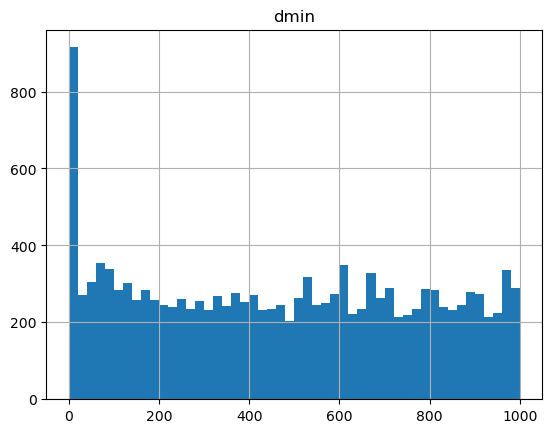

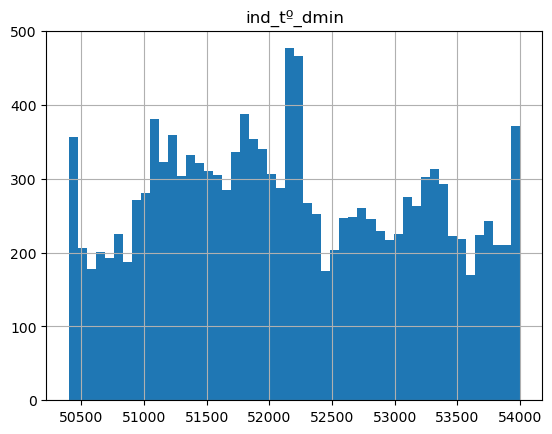

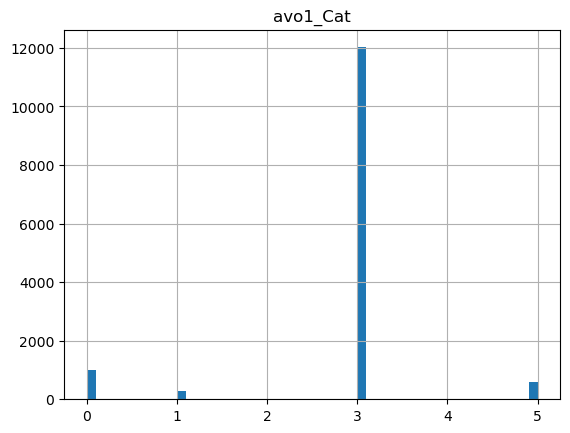

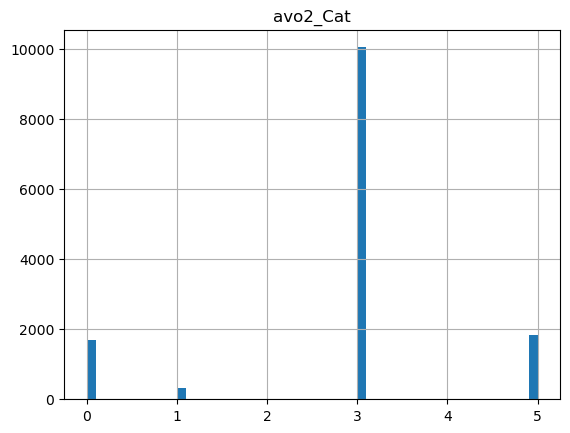

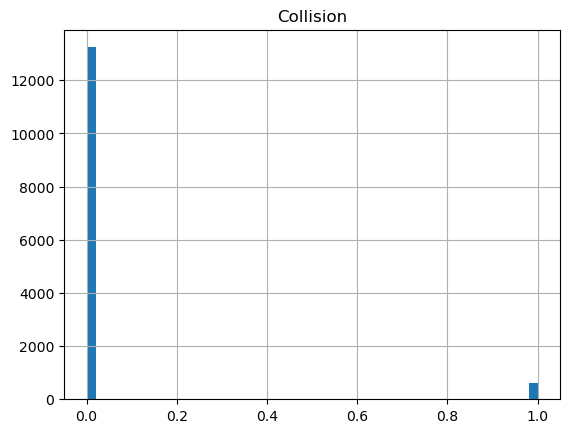

In [4]:
df_dmin.hist(column='dmin', bins=50)
df_dmin.hist(column='ind_tº_dmin', bins=50)
df_dmin.hist(column='avo1_Cat', bins=50)
df_dmin.hist(column='avo2_Cat', bins=50)
df_dmin.hist(column='Collision', bins=50)

In [5]:
df_dmin.corr()

,avo1,avo2,ind_tº_dmin,dmin,Collision,avo1_ID_num,avo1_Cat,avo2_ID_num,avo2_Cat,dreal_t_dmin-0,...,dreal_t_dmin-60,dproj_t_dmin-60,dreal_t_dmin-70,dproj_t_dmin-70,dreal_t_dmin-80,dproj_t_dmin-80,dreal_t_dmin-90,dproj_t_dmin-90,dreal_t_dmin-100,dproj_t_dmin-100
avo1,1.000000,0.668657,-0.046968,-0.093433,-0.060693,-0.328145,-0.033986,-0.366830,0.078482,-0.093433,...,0.040050,-0.081439,0.047132,-0.075563,0.052800,-0.074198,0.058201,-0.078636,0.064230,-0.084286
avo2,0.668657,1.000000,-0.089426,0.048830,-0.238706,-0.208943,-0.024073,-0.408859,0.122755,0.048830,...,0.105848,0.026310,0.103183,0.015434,0.100281,0.008372,0.098855,0.001878,0.097977,-0.002953
ind_tº_dmin,-0.046968,-0.089426,1.000000,-0.025708,0.014276,-0.038993,0.149178,-0.018568,0.224865,-0.025708,...,0.103910,0.024736,0.103542,0.026242,0.102539,0.030091,0.102309,0.035594,0.101646,0.038314
dmin,-0.093433,0.048830,-0.025708,1.000000,-0.335474,0.085012,-0.058850,0.021137,-0.062808,1.000000,...,0.183305,0.563957,0.141719,0.478533,0.110081,0.399638,0.087634,0.327983,0.068357,0.292708
Collision,-0.060693,-0.238706,0.014276,-0.335474,1.000000,0.039660,0.055502,0.031793,0.035807,-0.335474,...,-0.162680,-0.185606,-0.134836,-0.161183,-0.106789,-0.137283,-0.082439,-0.115986,-0.058777,-0.103453
avo1_ID_num,-0.328145,-0.208943,-0.038993,0.085012,0.039660,1.000000,-0.106357,0.265637,-0.009155,0.085012,...,0.275107,0.147689,0.269730,0.173042,0.262624,0.196220,0.255291,0.209163,0.246029,0.213558
avo1_Cat,-0.033986,-0.024073,0.149178,-0.058850,0.055502,-0.106357,1.000000,-0.069738,0.051663,-0.058850,...,0.160821,-0.007768,0.169604,0.010665,0.176307,0.026506,0.181962,0.042941,0.185302,0.044543
avo2_ID_num,-0.366830,-0.408859,-0.018568,0.021137,0.031793,0.265637,-0.069738,1.000000,0.074687,0.021137,...,0.329778,0.193268,0.323995,0.226664,0.316336,0.256621,0.307224,0.294641,0.292551,0.308050
avo2_Cat,0.078482,0.122755,0.224865,-0.062808,0.035807,-0.009155,0.051663,0.074687,1.000000,-0.062808,...,0.467597,0.183184,0.471952,0.203954,0.473407,0.224415,0.474912,0.251799,0.470919,0.259204
dreal_t_dmin-0,-0.093433,0.048830,-0.025708,1.000000,-0.335474,0.085012,-0.058850,0.021137,-0.062808,1.000000,...,0.183305,0.563957,0.141719,0.478533,0.110081,0.399638,0.087634,0.327983,0.068357,0.292708


In [6]:
pp=df_dmin.corr()['dmin']

In [7]:
type(pp)

pandas.core.series.Series

## <span style="color:red">Section 4: Applying Machine Learning (Support Vector Machine) to the Dataset

In [8]:
#filtering columns per name, we can retrieve values only for distance along time
dreal_ev = pp.filter(regex='dreal_t_dmin')
dproj_ev = pp.filter(regex='dproj_t_dmin')

dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
#from os import listdir
#from os.path import isfile, join
import re
m=[]
for line in dmin_cols:
    m.append(re.search('dreal_t_dmin-(.*)', line).group(1))
print(m)

['0', '1', '2', '3', '4', '5', '10', '15', '20', '25', '30', '40', '50', '60', '70', '80', '90', '100']


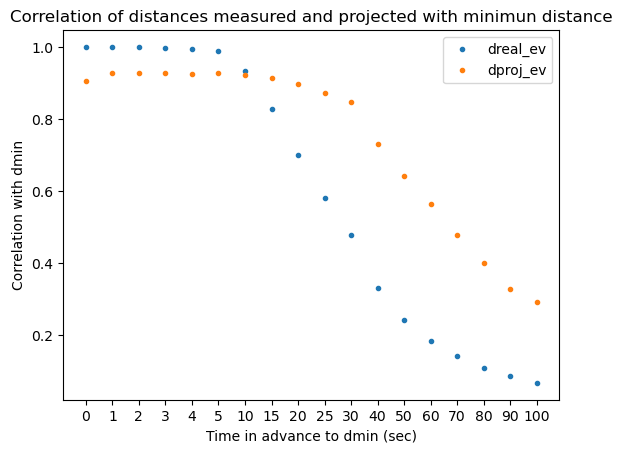

In [9]:
#the following picture shows how the correlation with dmin decreases with time for distantece measuered and projected
fig, ax = plt.subplots()
ax.plot(m, dreal_ev, '.', label='dreal_ev')
ax.plot(m, dproj_ev, '.', label='dproj_ev')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('Correlation with dmin')
ax.set_title('Correlation of distances measured and projected with minimun distance')
ax.legend()

# First Partial Conclusion
### Up to 10 seconds before the minimum distance timespot, there is a greater correlation among the real distance n seconds before this timespot and the minimum distance. But at earlier times in advance, the correlation of the projected minimum distance is greater.

In [10]:
#Filter dataframe to analyse only columns with distance calculated at different times ahead from the minimum distance timespot
dreal_ev1=df_dmin.filter(regex='dreal_t_dmin')
dreal_ev1.head()

,dreal_t_dmin-0,dreal_t_dmin-1,dreal_t_dmin-2,dreal_t_dmin-3,dreal_t_dmin-4,dreal_t_dmin-5,dreal_t_dmin-10,dreal_t_dmin-15,dreal_t_dmin-20,dreal_t_dmin-25,dreal_t_dmin-30,dreal_t_dmin-40,dreal_t_dmin-50,dreal_t_dmin-60,dreal_t_dmin-70,dreal_t_dmin-80,dreal_t_dmin-90,dreal_t_dmin-100
0,453.635322,453.762150,454.176874,454.878710,455.866329,457.137880,467.655464,484.731658,507.705115,535.817826,568.307625,643.683815,729.290896,821.893773,919.401228,1020.408222,1123.971681,1229.445737
1,400.498491,400.561029,401.213843,402.454061,404.276277,406.672668,426.847884,459.182330,501.328781,551.040398,606.459671,729.100455,861.807965,1000.584739,1143.222650,1288.439983,1435.454112,1583.764749
2,534.137961,534.585739,535.538722,536.994222,538.948167,541.395160,560.754484,591.027900,630.645606,677.971457,731.510921,852.425148,986.040109,1127.850884,1275.125954,1426.173494,1579.911875,1735.626195
3,240.598770,241.129207,242.451614,244.553145,247.413946,251.008058,278.785643,319.432212,368.716088,423.633430,482.263543,606.301202,735.541040,867.661541,1001.523304,1136.511222,1272.266891,1408.568343
4,100.357338,100.859229,102.401593,104.938564,108.400330,112.701706,143.682265,177.386921,193.998998,225.317470,266.201376,363.238450,469.970858,581.080443,694.469432,809.180166,924.720891,1040.815233


In [11]:
#Antoher way to filter dataframe to analyse only columns with distance calculated at different times ahead from the minimum distance timespot
dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
#dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col or 'dproj_t_dmin' in col]
df1=df_dmin[dmin_cols]
df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin']]
dreal_ev2=pd.concat([df2, df1], axis=1)
dreal_ev2.head()

,avo1_ID_num,avo2_ID_num,ind_tº_dmin,dmin,dreal_t_dmin-0,dreal_t_dmin-1,dreal_t_dmin-2,dreal_t_dmin-3,dreal_t_dmin-4,dreal_t_dmin-5,...,dreal_t_dmin-20,dreal_t_dmin-25,dreal_t_dmin-30,dreal_t_dmin-40,dreal_t_dmin-50,dreal_t_dmin-60,dreal_t_dmin-70,dreal_t_dmin-80,dreal_t_dmin-90,dreal_t_dmin-100
0,2307,3000,51298.0,453.635322,453.635322,453.762150,454.176874,454.878710,455.866329,457.137880,...,507.705115,535.817826,568.307625,643.683815,729.290896,821.893773,919.401228,1020.408222,1123.971681,1229.445737
1,2307,3005,51447.0,400.498491,400.498491,400.561029,401.213843,402.454061,404.276277,406.672668,...,501.328781,551.040398,606.459671,729.100455,861.807965,1000.584739,1143.222650,1288.439983,1435.454112,1583.764749
2,2307,3012,51223.0,534.137961,534.137961,534.585739,535.538722,536.994222,538.948167,541.395160,...,630.645606,677.971457,731.510921,852.425148,986.040109,1127.850884,1275.125954,1426.173494,1579.911875,1735.626195
3,2307,3037,51527.0,240.598770,240.598770,241.129207,242.451614,244.553145,247.413946,251.008058,...,368.716088,423.633430,482.263543,606.301202,735.541040,867.661541,1001.523304,1136.511222,1272.266891,1408.568343
4,2307,3050,51766.0,100.357338,100.357338,100.859229,102.401593,104.938564,108.400330,112.701706,...,193.998998,225.317470,266.201376,363.238450,469.970858,581.080443,694.469432,809.180166,924.720891,1040.815233


In [12]:
#To evaluate the correlation depending on the time in advance with respect to the minimun distance timespot, we have to drop the closest time columns
dmin_cols_prev=dmin_cols.copy()
del dmin_cols_prev[0:1]

df1=df_dmin[dmin_cols_prev]
df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin']]
dreal_ev2=pd.concat([df2, df1], axis=1)
dreal_ev2.head()

,avo1_ID_num,avo2_ID_num,ind_tº_dmin,dmin,dreal_t_dmin-1,dreal_t_dmin-2,dreal_t_dmin-3,dreal_t_dmin-4,dreal_t_dmin-5,dreal_t_dmin-10,...,dreal_t_dmin-20,dreal_t_dmin-25,dreal_t_dmin-30,dreal_t_dmin-40,dreal_t_dmin-50,dreal_t_dmin-60,dreal_t_dmin-70,dreal_t_dmin-80,dreal_t_dmin-90,dreal_t_dmin-100
0,2307,3000,51298.0,453.635322,453.762150,454.176874,454.878710,455.866329,457.137880,467.655464,...,507.705115,535.817826,568.307625,643.683815,729.290896,821.893773,919.401228,1020.408222,1123.971681,1229.445737
1,2307,3005,51447.0,400.498491,400.561029,401.213843,402.454061,404.276277,406.672668,426.847884,...,501.328781,551.040398,606.459671,729.100455,861.807965,1000.584739,1143.222650,1288.439983,1435.454112,1583.764749
2,2307,3012,51223.0,534.137961,534.585739,535.538722,536.994222,538.948167,541.395160,560.754484,...,630.645606,677.971457,731.510921,852.425148,986.040109,1127.850884,1275.125954,1426.173494,1579.911875,1735.626195
3,2307,3037,51527.0,240.598770,241.129207,242.451614,244.553145,247.413946,251.008058,278.785643,...,368.716088,423.633430,482.263543,606.301202,735.541040,867.661541,1001.523304,1136.511222,1272.266891,1408.568343
4,2307,3050,51766.0,100.357338,100.859229,102.401593,104.938564,108.400330,112.701706,143.682265,...,193.998998,225.317470,266.201376,363.238450,469.970858,581.080443,694.469432,809.180166,924.720891,1040.815233


In [13]:
#Same operations with dproj, instead of dreal
dproj_cols = [col for col in df_dmin if 'dproj_t_dmin' in col]
dproj_cols_prev=dproj_cols.copy()
del dproj_cols_prev[0:1]

df11=df_dmin[dproj_cols_prev]
df21=df_dmin[['avo1','avo2','ind_tº_dmin','dmin']]
dproj_ev2=pd.concat([df21, df11], axis=1)
dproj_ev2.head()

,avo1,avo2,ind_tº_dmin,dmin,dproj_t_dmin-1,dproj_t_dmin-2,dproj_t_dmin-3,dproj_t_dmin-4,dproj_t_dmin-5,dproj_t_dmin-10,...,dproj_t_dmin-20,dproj_t_dmin-25,dproj_t_dmin-30,dproj_t_dmin-40,dproj_t_dmin-50,dproj_t_dmin-60,dproj_t_dmin-70,dproj_t_dmin-80,dproj_t_dmin-90,dproj_t_dmin-100
0,0.0,38.0,51298.0,453.635322,453.634806,453.634806,453.634806,453.634806,453.634806,453.634806,...,453.634806,453.634806,453.634806,453.634806,453.674030,453.674030,453.674030,453.674030,453.674030,453.674030
1,0.0,42.0,51447.0,400.498491,400.452587,400.452587,400.452587,400.452587,400.452587,400.452587,...,400.452587,400.452587,400.452587,400.452587,400.452587,400.452587,400.452587,400.452587,400.452587,400.452587
2,0.0,47.0,51223.0,534.137961,534.100577,534.100577,534.100577,534.100577,534.100577,534.100577,...,534.100577,534.100577,534.100577,534.100577,534.100577,534.100577,534.100577,534.100577,534.100577,534.100577
3,0.0,59.0,51527.0,240.598770,240.587843,240.587843,240.587843,240.587843,240.587843,240.587843,...,240.587843,240.587843,240.587843,240.587843,240.587843,240.587843,240.587843,240.587843,240.587843,240.587843
4,0.0,63.0,51766.0,100.357338,100.357013,100.357013,100.357013,100.357013,100.357013,100.357013,...,175.918296,175.918296,175.918296,175.918296,175.918296,175.918296,175.918296,175.918296,175.918296,175.918296


In [61]:
del dmin_cols_prev[0:2]
dmin_cols_prev

['dreal_t_dmin-2',
 'dreal_t_dmin-3',
 'dreal_t_dmin-4',
 'dreal_t_dmin-5',
 'dreal_t_dmin-10',
 'dreal_t_dmin-15',
 'dreal_t_dmin-20',
 'dreal_t_dmin-25',
 'dreal_t_dmin-30',
 'dreal_t_dmin-40',
 'dreal_t_dmin-50',
 'dreal_t_dmin-60',
 'dreal_t_dmin-70',
 'dreal_t_dmin-80',
 'dreal_t_dmin-90',
 'dreal_t_dmin-100']

In [15]:
    df1=df_dmin[dmin_cols_prev]
    df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dreal_ev2=pd.concat([df2, df1], axis=1)
    
    dreal_ev2b = dreal_ev2.dropna()
    
    Xreal=dreal_ev2b[dmin_cols_prev].values
    yreal=dreal_ev2b['Collision'].values

In [17]:
from sklearn.model_selection import train_test_split
Xreal_train, Xreal_test, yreal_train, yreal_test = train_test_split( Xreal, yreal, test_size=0.2, random_state=4)

In [60]:
#Comparo los diferentes Kernels para SVM. Linear>poly>rbf>sigmoid
from sklearn import svm
clf = svm.SVC(kernel='linear',class_weight={0: 0.50963869,1: 26.43712575})
clf.fit(Xreal_train, yreal_train) 
ypred_test = clf.predict(Xreal_test)

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yreal_test , ypred_test)

array([[2114,   49],
       [   2,   43]], dtype=int64)

In [62]:
from sklearn.metrics import  classification_report
print(classification_report(yreal_test , ypred_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2163
           1       0.47      0.96      0.63        45

    accuracy                           0.98      2208
   macro avg       0.73      0.97      0.81      2208
weighted avg       0.99      0.98      0.98      2208



In [59]:
from sklearn.utils.class_weight import compute_class_weight

compute_class_weight(class_weight="balanced", classes=np.unique(yreal_train), y=yreal_train)

array([ 0.50963869, 26.43712575])

# <span style="color:red">Section 5: Tuning ANN Hyperparameters

## Hyperparameter optimisation:

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b
https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/
https://www.kaggle.com/code/jhskaggle/l21-artificial-neural-networks-ii
https://sklearner.com/sklearn-mlpclassifier-hidden_layer_sizes-parameter/

For future, advanced optimisation:
https://devskrol.com/2021/12/22/advanced-hyperparameter-tuning-of-a-multilayer-perceptron-mlp/


## Tuning prediction based on Real Distance

In [8]:
import numpy as np
red=0
MARGEN_CHOQUE=50 #if MARGEN_CHOQUE>200, the classification would be balanced and the predicition would work very well
df_dmin['Collision']=np.where(df_dmin['dmin']<=MARGEN_CHOQUE,1,0)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

k_real=[]
#k_proj=[]
#k_tot=[]
jaccard_score_ANN_real=[]
f1_score_ANN_real=[]
accuracy_ANN_real=[]
confusion_ANN_real=[]
classif_report_ANN_real=[]
precision_conf_real=[]
recall_conf_real=[]
precisionPR_real=[]
recallPR_real=[]
pr_auc_real=[]
param_real=[]
estimator_real=[]

mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,),(50,100,)],
    'activation': ['identity', 'logistic','tanh', 'relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

import warnings
warnings.filterwarnings('ignore')

dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
for i in range(len(dmin_cols)-red):
    dmin_cols_prev=dmin_cols.copy()
    del dmin_cols_prev[0:i]
    
    df1=df_dmin[dmin_cols_prev]
    df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dreal_ev2=pd.concat([df2, df1], axis=1)
    
    dreal_ev2b = dreal_ev2.dropna()
    
    Xreal=dreal_ev2b[dmin_cols_prev].values
    yreal=dreal_ev2b['Collision'].values
    
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    Xreal = preprocessing.StandardScaler().fit(Xreal).transform(Xreal.astype(float))
    
    Xreal_train, Xreal_test, yreal_train, yreal_test = train_test_split( Xreal, yreal, test_size=0.2, random_state=4)
    
   
    #Train Model and Predict 
    ann_real_tune = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
    ann_real_tune.fit(Xreal_train,yreal_train) 
    param_real.append(ann_real_tune.best_estimator_)
    estimator_real.append(ann_real_tune.best_estimator_)
    
    ann_real = MLPClassifier(**ann_real_tune.best_params_).fit(Xreal_train,yreal_train)
    #ann_real = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1, warm_start=True).fit(Xreal_train,yreal_train)
    ypred_test = ann_real.predict(Xreal_test)
    
    
    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_ANN_real.append(jaccard_score(yreal_test , ypred_test))
    f1_score_ANN_real.append(f1_score(yreal_test , ypred_test, pos_label=1, average='binary'))
    accuracy_ANN_real.append(accuracy_score(yreal_test , ypred_test))
    conf=confusion_matrix(yreal_test , ypred_test)
    confusion_ANN_real.append(conf)
    classif_report_ANN_real.append(classification_report(yreal_test , ypred_test))
    precision_conf_real.append(conf[1][1]/(conf[1][1]+conf[0][1]))
    recall_conf_real.append(conf[1][1]/(conf[1][1]+conf[1][0]))
    precisionPR_real1, recallPR_real1, _ = precision_recall_curve(yreal_test , ypred_test)
    precisionPR_real.append(precisionPR_real1)
    recallPR_real.append(recallPR_real1)
    pr_auc_real.append(auc(recallPR_real1,precisionPR_real1))

['0', '1', '2', '3', '4', '5', '10', '15', '20', '25', '30', '40', '50', '60', '70', '80', '90', '100']


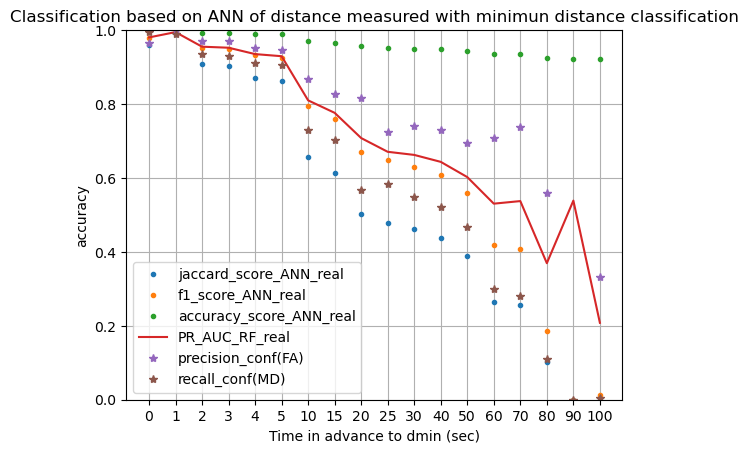

In [10]:
#the following picture shows how the classification scores decreases with time for distance measured and projected

#dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]

import re
m=[]
for line in dmin_cols:
    m.append(re.search('dreal_t_dmin-(.*)', line).group(1))
print(m)

m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_ANN_real, '.', label='jaccard_score_ANN_real')
ax.plot(m1, f1_score_ANN_real, '.', label='f1_score_ANN_real')
ax.plot(m1, accuracy_ANN_real, '.', label='accuracy_score_ANN_real')

ax.plot(m1, pr_auc_real, '-', label='PR_AUC_RF_real')
ax.plot(m1, precision_conf_real, '*', label='precision_conf(FA)')
ax.plot(m1, recall_conf_real, '*', label='recall_conf(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Classification based on ANN of distance measured with minimun distance classification')
ax.legend()

In [12]:
df_conf_ANN=pd.DataFrame()
df_conf_ANN['seconds to dmin']=m
df_conf_ANN['conf_real']=confusion_ANN_real
df_conf_ANN['f1_score_ANN_real']=f1_score_ANN_real
df_conf_ANN['PR_AUC_ANN_real']=pr_auc_real
df_conf_ANN['param_real']=param_real
df_conf_ANN['estimator_real']=estimator_real
df_conf_ANN.to_csv('Results_ANN_real.csv', index=True)
df_conf_ANN.to_excel('Results_ANN_real.xlsx', index=False)
df_conf_ANN

,seconds to dmin,conf_real,f1_score_ANN_real,PR_AUC_ANN_real,param_real,estimator_real
0,0,"[[2031, 6], [1, 170]]",0.979827,0.980257,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
1,1,"[[2037, 0], [2, 169]]",0.994118,0.994605,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
2,2,"[[2032, 5], [11, 160]]",0.952381,0.955176,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
3,3,"[[2032, 5], [12, 159]]",0.949254,0.952386,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
4,4,"[[2029, 8], [15, 156]]",0.931343,0.935147,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
5,5,"[[2028, 9], [16, 155]]",0.925373,0.929401,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
6,10,"[[2018, 19], [46, 125]]",0.793651,0.809942,"MLPClassifier(activation='tanh', hidden_layer_...","MLPClassifier(activation='tanh', hidden_layer_..."
7,15,"[[2012, 25], [51, 120]]",0.759494,0.776219,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."
8,20,"[[2015, 22], [74, 97]]",0.668966,0.707946,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."
9,25,"[[1999, 38], [71, 100]]",0.647249,0.670794,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."


In [ ]:
#Probar ajustes con esta configuración

MLPClassifier(activation='identity', hidden_layer_sizes=(50, 100),
              learning_rate='adaptive', max_iter=100, solver='lbfgs')


In [27]:
#df_read=pd.read_csv('Results_SVC_real.csv') 
df_read=pd.read_excel('Results_SVC_real.xlsx') 
df_read

,conf_real,f1_score_SVC_real,PR_AUC_SVC_real,param_real
0,[[2034 3]\n [ 11 160]],0.958084,0.961125,"SVC(C=100, class_weight={0: 0.5, 1: 0.5}, gamm..."
1,[[2031 6]\n [ 12 159]],0.946429,0.949448,"SVC(C=1000, class_weight={0: 0.1, 1: 0.9}, gam..."
2,[[2030 7]\n [ 14 157]],0.937313,0.940893,"SVC(C=1000, class_weight={0: 0.3, 1: 0.7}, gam..."
3,[[2032 5]\n [ 28 143]],0.896552,0.907577,"SVC(C=1000, class_weight={0: 0.9, 1: 0.0999999..."
4,[[2014 23]\n [ 12 159]],0.900850,0.904443,"SVC(C=1000, class_weight={0: 0.1, 1: 0.9}, gam..."
5,[[2025 12]\n [ 20 151]],0.904192,0.909240,"SVC(C=100, class_weight={0: 0.5, 1: 0.5}, gamm..."
6,[[1991 46]\n [ 18 153]],0.827027,0.835867,"SVC(C=1000, class_weight={0: 0.3, 1: 0.7}, gam..."
7,[[2031 6]\n [ 120 51]],0.447368,0.623665,"SVC(C=10, class_weight={0: 0.7, 1: 0.300000000..."
8,[[2031 6]\n [ 158 13]],0.136842,0.415896,"SVC(C=10, class_weight={0: 0.8, 1: 0.199999999..."
9,[[2036 1]\n [ 171 0]],0.000000,0.038723,"SVC(C=100, class_weight={0: 0.9, 1: 0.09999999..."


# Tuning prediction based on Projected Distance

In [8]:
import numpy as np
red=0
MARGEN_CHOQUE=50 #if MARGEN_CHOQUE>200, the classification would be balanced and the predicition would work very well
df_dmin['Collision']=np.where(df_dmin['dmin']<=MARGEN_CHOQUE,1,0)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#k_real=[]
k_proj=[]
#k_tot=[]
jaccard_score_ANN_proj=[]
f1_score_ANN_proj=[]
accuracy_ANN_proj=[]
confusion_ANN_proj=[]
classif_report_ANN_proj=[]
precision_conf_proj=[]
recall_conf_proj=[]
precisionPR_proj=[]
recallPR_proj=[]
pr_auc_proj=[]
param_proj=[]
estimator_proj=[]

mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,),(50,100,)],
    'activation': ['identity', 'logistic','tanh', 'relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

import warnings
warnings.filterwarnings('ignore')

#dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
dproj_cols = [col for col in df_dmin if 'dproj_t_dmin' in col]
for i in range(len(dproj_cols)-red):
    dproj_cols_prev=dproj_cols.copy()
    del dproj_cols_prev[0:i]
    
    df11=df_dmin[dproj_cols_prev]
    df21=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dproj_ev2=pd.concat([df21, df11], axis=1)

    dproj_ev2b = dproj_ev2.dropna()

    Xproj=dproj_ev2b[dproj_cols_prev].values
    yproj=dproj_ev2b['Collision'].values

        
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    Xproj = preprocessing.StandardScaler().fit(Xproj).transform(Xproj.astype(float))
    
    Xproj_train, Xproj_test, yproj_train, yproj_test = train_test_split( Xproj, yproj, test_size=0.2, random_state=4)
    
       
    #Train Model and Predict 
    ann_proj_tune = GridSearchCV(mlp_gs, parameter_space, scoring='f1', n_jobs=-1, cv=5)
    ann_proj_tune.fit(Xproj_train,yproj_train) 
    
    param_proj.append(ann_proj_tune.best_estimator_)
    estimator_proj.append(ann_proj_tune.best_estimator_)
    
    ann_proj = MLPClassifier(**ann_proj_tune.best_params_).fit(Xproj_train,yproj_train)
    ypred_proj_test = ann_proj.predict(Xproj_test)    


    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_ANN_proj.append(jaccard_score(yproj_test , ypred_proj_test))
    f1_score_ANN_proj.append(f1_score(yproj_test , ypred_proj_test, pos_label=1, average='binary'))
    accuracy_ANN_proj.append(accuracy_score(yproj_test , ypred_proj_test))
    conf_proj=confusion_matrix(yproj_test , ypred_proj_test)
    confusion_ANN_proj.append(conf_proj)
    classif_report_ANN_proj.append(classification_report(yproj_test , ypred_proj_test))
    precision_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[0][1]))
    recall_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[1][0]))
    precisionPR_proj1, recallPR_proj1, _ = precision_recall_curve(yproj_test , ypred_proj_test)
    precisionPR_proj.append(precisionPR_proj1)
    recallPR_proj.append(recallPR_proj1)
    pr_auc_proj.append(auc(recallPR_proj1,precisionPR_proj1))

['0', '1', '2', '3', '4', '5', '10', '15', '20', '25', '30', '40', '50', '60', '70', '80', '90', '100']


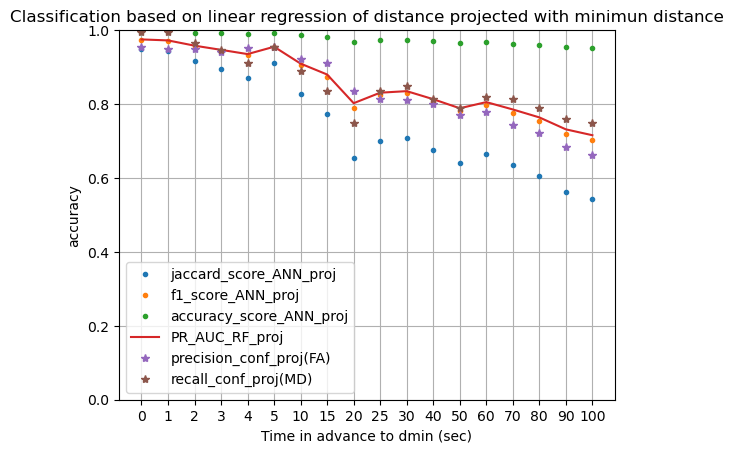

In [9]:
#the following picture shows how the classification scores decreases with time for distance measured and projected

dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]

import re
m=[]
for line in dmin_cols:
    m.append(re.search('dreal_t_dmin-(.*)', line).group(1))
print(m)

m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_ANN_proj, '.', label='jaccard_score_ANN_proj')
ax.plot(m1, f1_score_ANN_proj, '.', label='f1_score_ANN_proj')
ax.plot(m1, accuracy_ANN_proj, '.', label='accuracy_score_ANN_proj')

ax.plot(m1, pr_auc_proj, '-', label='PR_AUC_RF_proj')
ax.plot(m1, precision_conf_proj, '*', label='precision_conf_proj(FA)')
ax.plot(m1, recall_conf_proj, '*', label='recall_conf_proj(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Classification based on linear regression of distance projected with minimun distance')
ax.legend()

In [10]:
df_conf_ANNpr=pd.DataFrame()
df_conf_ANNpr['seconds to dmin']=m
df_conf_ANNpr['conf_proj']=confusion_ANN_proj
df_conf_ANNpr['f1_score_RF_proj']=f1_score_ANN_proj
df_conf_ANNpr['PR_AUC_RF_proj']=pr_auc_proj
df_conf_ANNpr['param_proj']=param_proj
df_conf_ANNpr['estimator_proj']=estimator_proj
df_conf_ANNpr.to_csv('Results_ANN_proj.csv', index=True)
df_conf_ANNpr.to_excel('Results_ANN_proj.xlsx', index=False)
df_conf_ANNpr

,seconds to dmin,conf_proj,f1_score_RF_proj,PR_AUC_RF_proj,param_proj,estimator_proj
0,0,"[[2029, 8], [1, 170]]",0.974212,0.974831,"MLPClassifier(activation='logistic', alpha=0.0...","MLPClassifier(activation='logistic', alpha=0.0..."
1,1,"[[2028, 9], [1, 170]]",0.971429,0.972163,"MLPClassifier(activation='logistic', hidden_la...","MLPClassifier(activation='logistic', hidden_la..."
2,2,"[[2028, 9], [6, 165]]",0.956522,0.957953,"MLPClassifier(alpha=0.05, hidden_layer_sizes=(...","MLPClassifier(alpha=0.05, hidden_layer_sizes=(..."
3,3,"[[2027, 10], [9, 162]]",0.944606,0.946652,"MLPClassifier(activation='logistic', hidden_la...","MLPClassifier(activation='logistic', hidden_la..."
4,4,"[[2029, 8], [15, 156]]",0.931343,0.935147,"MLPClassifier(activation='logistic', hidden_la...","MLPClassifier(activation='logistic', hidden_la..."
5,5,"[[2029, 8], [8, 163]]",0.953216,0.955028,"MLPClassifier(hidden_layer_sizes=(10, 30, 10),...","MLPClassifier(hidden_layer_sizes=(10, 30, 10),..."
6,10,"[[2024, 13], [19, 152]]",0.904762,0.909353,"MLPClassifier(activation='logistic', alpha=0.0...","MLPClassifier(activation='logistic', alpha=0.0..."
7,15,"[[2023, 14], [28, 143]]",0.871951,0.879883,"MLPClassifier(activation='logistic', hidden_la...","MLPClassifier(activation='logistic', hidden_la..."
8,20,"[[2012, 25], [43, 128]]",0.790123,0.802307,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."
9,25,"[[2004, 33], [28, 143]]",0.824207,0.830719,"MLPClassifier(activation='tanh', hidden_layer_...","MLPClassifier(activation='tanh', hidden_layer_..."


In [12]:
#df_read=pd.read_csv('Results_SVC_real.csv') 
df_read=pd.read_excel('Results_SVC_proj.xlsx') 
df_read

,conf_proj,f1_score_SVC_proj,PR_AUC_SVC_proj,param_proj,estimator_proj
0,[[2023 14]\n [ 14 157]],0.918129,0.921299,"{'C': 100, 'class_weight': {0: 0.2, 1: 0.8}, '...","SVC(C=100, class_weight={0: 0.2, 1: 0.8}, gamm..."
1,[[2028 9]\n [ 16 155]],0.925373,0.929401,"{'C': 10, 'class_weight': {0: 0.5, 1: 0.5}, 'g...","SVC(C=10, class_weight={0: 0.5, 1: 0.5}, gamma..."
2,[[2023 14]\n [ 15 156]],0.914956,0.918361,"{'C': 100, 'class_weight': {0: 0.2, 1: 0.8}, '...","SVC(C=100, class_weight={0: 0.2, 1: 0.8}, gamm..."
3,[[2028 9]\n [ 15 156]],0.928571,0.932264,"{'C': 10, 'class_weight': {0: 0.5, 1: 0.5}, 'g...","SVC(C=10, class_weight={0: 0.5, 1: 0.5}, gamma..."
4,[[2025 12]\n [ 15 156]],0.920354,0.923823,"{'C': 100, 'class_weight': {0: 0.4, 1: 0.6}, '...","SVC(C=100, class_weight={0: 0.4, 1: 0.6}, gamm..."
5,[[2024 13]\n [ 16 155]],0.914454,0.918149,"{'C': 100, 'class_weight': {0: 0.5, 1: 0.5}, '...","SVC(C=100, class_weight={0: 0.5, 1: 0.5}, gamm..."
6,[[2026 11]\n [ 32 139]],0.866044,0.877012,"{'C': 10, 'class_weight': {0: 0.6, 1: 0.4}, 'g...","SVC(C=10, class_weight={0: 0.6, 1: 0.4}, gamma..."
7,[[2029 8]\n [ 54 117]],0.790541,0.822334,"{'C': 10, 'class_weight': {0: 0.7, 1: 0.300000...","SVC(C=10, class_weight={0: 0.7, 1: 0.300000000..."
8,[[2029 8]\n [ 87 84]],0.638783,0.721837,"{'C': 100, 'class_weight': {0: 0.9, 1: 0.09999...","SVC(C=100, class_weight={0: 0.9, 1: 0.09999999..."
9,[[2034 3]\n [ 107 64]],0.537815,0.688977,"{'C': 10, 'class_weight': {0: 0.8, 1: 0.199999...","SVC(C=10, class_weight={0: 0.8, 1: 0.199999999..."


In [15]:
param_proj

[{'C': 100, 'class_weight': {0: 0.2, 1: 0.8}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 10, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 100, 'class_weight': {0: 0.2, 1: 0.8}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 10, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 100, 'class_weight': {0: 0.4, 1: 0.6}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 100, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 10,
  'class_weight': {0: 0.7, 1: 0.30000000000000004},
  'gamma': 1,
  'kernel': 'rbf'},
 {'C': 100,
  'class_weight': {0: 0.9, 1: 0.09999999999999998},
  'gamma': 1,
  'kernel': 'rbf'},
 {'C': 10,
  'class_weight': {0: 0.8, 1: 0.19999999999999996},
  'gamma': 0.1,
  'kernel': 'rbf'},
 {'C': 0.1, 'class_weight': {0: 0.4, 1: 0.6}, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 1,
  'class_weight': {0: 0.7, 1: 0.30000000000000004},
  'gamma': 1,
  'kernel': 'rbf'},
 {'C'

### Ajuste de Parámetros

In [24]:
import numpy as np
red=0
MARGEN_CHOQUE=50 #if MARGEN_CHOQUE>200, the classification would be balanced and the predicition would work very well
df_dmin['Collision']=np.where(df_dmin['dmin']<=MARGEN_CHOQUE,1,0)

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#k_real=[]
k_proj=[]
#k_tot=[]
jaccard_score_SVM_proj=[]
f1_score_SVM_proj=[]
accuracy_SVM_proj=[]
confusion_SVM_proj=[]
classif_report_SVM_proj=[]
precision_conf_proj=[]
recall_conf_proj=[]
precisionPR_proj=[]
recallPR_proj=[]
pr_auc_proj=[]
param_proj=[]
estimator_proj=[]

#Chosen parameter
param = {'C': 10, 'class_weight': {0: 0.3, 1: 0.7}, 'gamma': 1, 'kernel': 'linear'}

import warnings
warnings.filterwarnings('ignore')

#dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
dproj_cols = [col for col in df_dmin if 'dproj_t_dmin' in col]
for i in range(len(dproj_cols)-red):
    dproj_cols_prev=dproj_cols.copy()
    del dproj_cols_prev[0:i]
    
    df11=df_dmin[dproj_cols_prev]
    df21=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dproj_ev2=pd.concat([df21, df11], axis=1)

    dproj_ev2b = dproj_ev2.dropna()

    Xproj=dproj_ev2b[dproj_cols_prev].values
    yproj=dproj_ev2b['Collision'].values

        
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    Xproj = preprocessing.StandardScaler().fit(Xproj).transform(Xproj.astype(float))
    
    Xproj_train, Xproj_test, yproj_train, yproj_test = train_test_split( Xproj, yproj, test_size=0.2, random_state=4)
    
       
    #Train Model and Predict 
    
    svc_proj = svm.SVC(**param).fit(Xproj_train,yproj_train)
    ypred_proj_test = svc_proj.predict(Xproj_test)

    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_SVM_proj.append(jaccard_score(yproj_test , ypred_proj_test))
    f1_score_SVM_proj.append(f1_score(yproj_test , ypred_proj_test, pos_label=1, average='binary'))
    accuracy_SVM_proj.append(accuracy_score(yproj_test , ypred_proj_test))
    conf_proj=confusion_matrix(yproj_test , ypred_proj_test)
    confusion_SVM_proj.append(conf_proj)
    classif_report_SVM_proj.append(classification_report(yproj_test , ypred_proj_test))
    precision_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[0][1]))
    recall_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[1][0]))
    precisionPR_proj1, recallPR_proj1, _ = precision_recall_curve(yproj_test , ypred_proj_test)
    precisionPR_proj.append(precisionPR_proj1)
    recallPR_proj.append(recallPR_proj1)
    pr_auc_proj.append(auc(recallPR_proj1,precisionPR_proj1))

['0', '1', '2', '3', '4', '5', '10', '15', '20', '25', '30', '40', '50', '60', '70', '80', '90', '100']


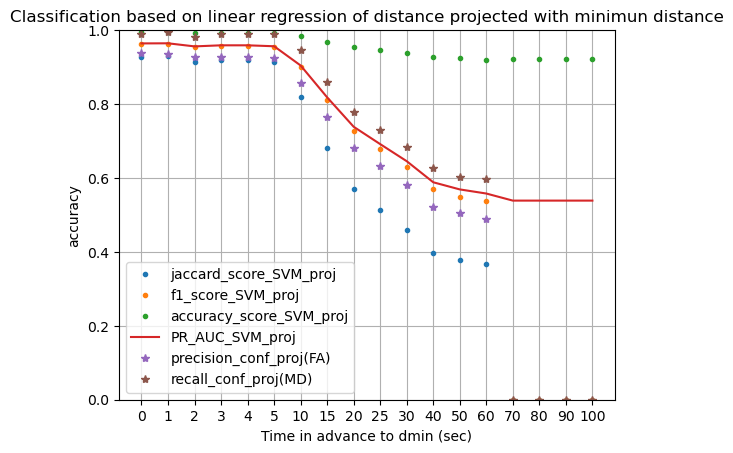

In [25]:
#the following picture shows how the classification scores decreases with time for distance measured and projected

dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]

import re
m=[]
for line in dmin_cols:
    m.append(re.search('dreal_t_dmin-(.*)', line).group(1))
print(m)

m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_SVM_proj, '.', label='jaccard_score_SVM_proj')
ax.plot(m1, f1_score_SVM_proj, '.', label='f1_score_SVM_proj')
ax.plot(m1, accuracy_SVM_proj, '.', label='accuracy_score_SVM_proj')

ax.plot(m1, pr_auc_proj, '-', label='PR_AUC_SVM_proj')
ax.plot(m1, precision_conf_proj, '*', label='precision_conf_proj(FA)')
ax.plot(m1, recall_conf_proj, '*', label='recall_conf_proj(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Classification based on linear regression of distance projected with minimun distance')
ax.legend()

In [26]:
df_conf_SVCprcomp=df_conf_SVCpr.copy()
df_conf_SVCprcomp['conf_proj_tuned_lin']=confusion_SVM_proj
df_conf_SVCprcomp['f1_score_SVC_proj_tuned_lin']=f1_score_SVM_proj
df_conf_SVCprcomp['PR_AUC_SVC_proj_tuned_lin']=pr_auc_proj
df_conf_SVCprcomp

,seconds to dmin,conf_proj,f1_score_SVC_proj,PR_AUC_SVC_proj,param_proj,estimator_proj,conf_proj_tuned_lin,f1_score_SVC_proj_tuned_lin,PR_AUC_SVC_proj_tuned_lin
0,0,"[[2023, 14], [14, 157]]",0.918129,0.921299,"{'C': 100, 'class_weight': {0: 0.2, 1: 0.8}, '...","SVC(C=100, class_weight={0: 0.2, 1: 0.8}, gamm...","[[2026, 11], [2, 169]]",0.962963,0.964049
1,1,"[[2028, 9], [16, 155]]",0.925373,0.929401,"{'C': 10, 'class_weight': {0: 0.5, 1: 0.5}, 'g...","SVC(C=10, class_weight={0: 0.5, 1: 0.5}, gamma...","[[2025, 12], [1, 170]]",0.963173,0.964335
2,2,"[[2023, 14], [15, 156]]",0.914956,0.918361,"{'C': 100, 'class_weight': {0: 0.2, 1: 0.8}, '...","SVC(C=100, class_weight={0: 0.2, 1: 0.8}, gamm...","[[2024, 13], [3, 168]]",0.954545,0.955996
3,3,"[[2028, 9], [15, 156]]",0.928571,0.932264,"{'C': 10, 'class_weight': {0: 0.5, 1: 0.5}, 'g...","SVC(C=10, class_weight={0: 0.5, 1: 0.5}, gamma...","[[2024, 13], [2, 169]]",0.957507,0.958891
4,4,"[[2025, 12], [15, 156]]",0.920354,0.923823,"{'C': 100, 'class_weight': {0: 0.4, 1: 0.6}, '...","SVC(C=100, class_weight={0: 0.4, 1: 0.6}, gamm...","[[2024, 13], [2, 169]]",0.957507,0.958891
5,5,"[[2024, 13], [16, 155]]",0.914454,0.918149,"{'C': 100, 'class_weight': {0: 0.5, 1: 0.5}, '...","SVC(C=100, class_weight={0: 0.5, 1: 0.5}, gamm...","[[2023, 14], [2, 169]]",0.954802,0.956354
6,10,"[[2026, 11], [32, 139]]",0.866044,0.877012,"{'C': 10, 'class_weight': {0: 0.6, 1: 0.4}, 'g...","SVC(C=10, class_weight={0: 0.6, 1: 0.4}, gamma...","[[2010, 27], [9, 162]]",0.900000,0.904294
7,15,"[[2029, 8], [54, 117]]",0.790541,0.822334,"{'C': 10, 'class_weight': {0: 0.7, 1: 0.300000...","SVC(C=10, class_weight={0: 0.7, 1: 0.300000000...","[[1992, 45], [24, 147]]",0.809917,0.818072
8,20,"[[2029, 8], [87, 84]]",0.638783,0.721837,"{'C': 100, 'class_weight': {0: 0.9, 1: 0.09999...","SVC(C=100, class_weight={0: 0.9, 1: 0.09999999...","[[1975, 62], [38, 133]]",0.726776,0.738520
9,25,"[[2034, 3], [107, 64]]",0.537815,0.688977,"{'C': 10, 'class_weight': {0: 0.8, 1: 0.199999...","SVC(C=10, class_weight={0: 0.8, 1: 0.199999999...","[[1964, 73], [46, 125]]",0.677507,0.691570


# Tuning prediction based on Real & Projected Distance

In [12]:
import numpy as np
red=0
MARGEN_CHOQUE=50 #if MARGEN_CHOQUE>200, the classification would be balanced and the predicition would work very well
df_dmin['Collision']=np.where(df_dmin['dmin']<=MARGEN_CHOQUE,1,0)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#k_real=[]
#k_proj=[]
k_tot=[]
jaccard_score_ANN_tot=[]
f1_score_ANN_tot=[]
accuracy_ANN_tot=[]
confusion_ANN_tot=[]
classif_report_ANN_tot=[]
precision_conf_tot=[]
recall_conf_tot=[]
precisionPR_tot=[]
recallPR_tot=[]
pr_auc_tot=[]
param_tot=[]
estimator_tot=[]


mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,),(50,100,)],
    'activation': ['identity', 'logistic','tanh', 'relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

import warnings
warnings.filterwarnings('ignore')

dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
#dproj_cols = [col for col in df_dmin if 'dproj_t_dmin' in col]
for i in range(len(dmin_cols)-red):
    dtot_cols = [col for col in df_dmin if 'dreal_t_dmin' in col or 'dproj_t_dmin' in col]
    dtot_cols_prev=dtot_cols.copy()
    del dtot_cols_prev[0:2*i]
    
    df1t=df_dmin[dtot_cols_prev]
    df2t=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dtot_ev2=pd.concat([df2t, df1t], axis=1)

    dtot_ev2b = dtot_ev2.dropna()

    Xtot=dtot_ev2b[dtot_cols_prev].values
    ytot=dtot_ev2b['Collision'].values
        
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    Xtot = preprocessing.StandardScaler().fit(Xtot).transform(Xtot.astype(float))
    
    Xtot_train, Xtot_test, ytot_train, ytot_test = train_test_split( Xtot, ytot, test_size=0.2, random_state=4)
       
    #Train Model and Predict 
    ann_tot_tune = GridSearchCV(mlp_gs, parameter_space, scoring='f1', n_jobs=-1, cv=5)
    ann_tot_tune.fit(Xtot_train,ytot_train) 
    
    param_tot.append(ann_tot_tune.best_estimator_)
    estimator_tot.append(ann_tot_tune.best_estimator_)
    
    ann_tot = MLPClassifier(**ann_tot_tune.best_params_).fit(Xtot_train,ytot_train)
    ypred_tot_test = ann_tot.predict(Xtot_test)   
    

    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_ANN_tot.append(jaccard_score(ytot_test , ypred_tot_test))
    f1_score_ANN_tot.append(f1_score(ytot_test , ypred_tot_test, pos_label=1, average='binary'))
    accuracy_ANN_tot.append(accuracy_score(ytot_test , ypred_tot_test))
    conf_tot=confusion_matrix(ytot_test , ypred_tot_test)
    confusion_ANN_tot.append(conf_tot)
    classif_report_ANN_tot.append(classification_report(ytot_test , ypred_tot_test))
    precision_conf_tot.append(conf_tot[1][1]/(conf_tot[1][1]+conf_tot[0][1]))
    recall_conf_tot.append(conf_tot[1][1]/(conf_tot[1][1]+conf_tot[1][0]))
    precisionPR_tot1, recallPR_tot1, _ = precision_recall_curve(ytot_test , ypred_tot_test)
    precisionPR_tot.append(precisionPR_tot1)
    recallPR_tot.append(recallPR_tot1)
    pr_auc_tot.append(auc(recallPR_tot1,precisionPR_tot1))        

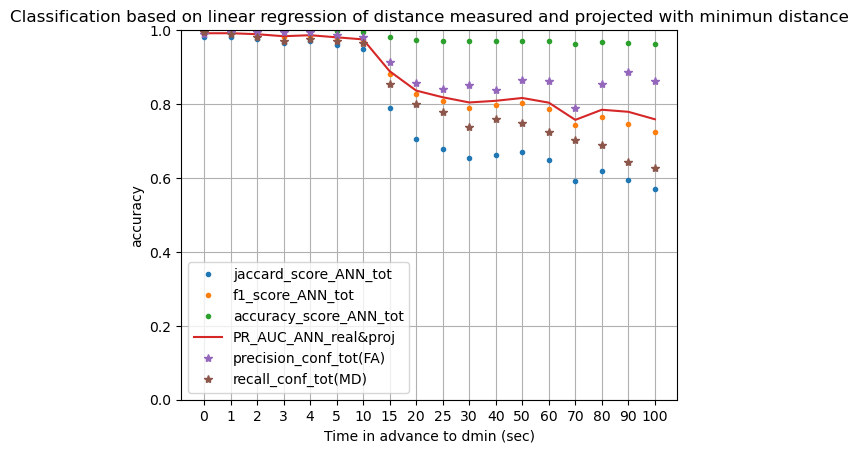

In [13]:
#the following picture shows how the classification scores decreases with time for distance measured and projected
m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_ANN_tot, '.', label='jaccard_score_ANN_tot')
ax.plot(m1, f1_score_ANN_tot, '.', label='f1_score_ANN_tot')
ax.plot(m1, accuracy_ANN_tot, '.', label='accuracy_score_ANN_tot')

ax.plot(m1, pr_auc_tot, '-', label='PR_AUC_ANN_real&proj')
ax.plot(m1, precision_conf_tot, '*', label='precision_conf_tot(FA)')
ax.plot(m1, recall_conf_tot, '*', label='recall_conf_tot(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Classification based on linear regression of distance measured and projected with minimun distance')
ax.legend()

In [16]:
df_conf_ANNtot=pd.DataFrame()
df_conf_ANNtot['seconds to dmin']=m
df_conf_ANNtot['conf_real&proj']=confusion_ANN_tot
df_conf_ANNtot['f1_score_ANN_real&proj']=f1_score_ANN_tot
df_conf_ANNtot['PR_AUC_ANN_real&proj']=pr_auc_tot
df_conf_ANNtot['param_real&proj']=param_tot
df_conf_ANNtot['estimator_real']=estimator_tot
df_conf_ANNtot.to_csv('Results_ANN_tot.csv', index=True)
df_conf_ANNtot.to_excel('Results_ANN_tot.xlsx', index=False)
df_conf_ANNtot

,seconds to dmin,conf_real&proj,f1_score_ANN_real&proj,PR_AUC_ANN_real&proj,param_real&proj,estimator_real
0,0,"[[2035, 2], [1, 170]]",0.991254,0.991489,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
1,1,"[[2036, 1], [2, 169]]",0.991202,0.991664,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
2,2,"[[2036, 1], [3, 168]]",0.988235,0.988949,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
3,3,"[[2036, 1], [5, 166]]",0.982249,0.983518,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
4,4,"[[2036, 1], [4, 167]]",0.985251,0.986234,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
5,5,"[[2035, 2], [5, 166]]",0.979351,0.980560,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
6,10,"[[2034, 3], [6, 165]]",0.973451,0.974886,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
7,15,"[[2023, 14], [25, 146]]",0.882175,0.888812,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
8,20,"[[2014, 23], [34, 137]]",0.827795,0.836409,"MLPClassifier(alpha=0.05, hidden_layer_sizes=(...","MLPClassifier(alpha=0.05, hidden_layer_sizes=(..."
9,25,"[[2012, 25], [38, 133]]",0.808511,0.818380,"MLPClassifier(hidden_layer_sizes=(50, 100), ma...","MLPClassifier(hidden_layer_sizes=(50, 100), ma..."


In [22]:
#df_read=pd.read_csv('Results_SVC_real.csv') 
df_read=pd.read_excel('Results_ANN_tot.xlsx') 
#df_read

### Comparison of Results

In [26]:
Results_ANN_real=pd.read_excel('Results_ANN_real.xlsx') 
Results_ANN_real

,seconds to dmin,conf_real,f1_score_ANN_real,PR_AUC_ANN_real,param_real,estimator_real
0,0,[[2031 6]\n [ 1 170]],0.979827,0.980257,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
1,1,[[2037 0]\n [ 2 169]],0.994118,0.994605,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
2,2,[[2032 5]\n [ 11 160]],0.952381,0.955176,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
3,3,[[2032 5]\n [ 12 159]],0.949254,0.952386,"MLPClassifier(activation='identity', hidden_la...","MLPClassifier(activation='identity', hidden_la..."
4,4,[[2029 8]\n [ 15 156]],0.931343,0.935147,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
5,5,[[2028 9]\n [ 16 155]],0.925373,0.929401,"MLPClassifier(activation='identity', alpha=0.0...","MLPClassifier(activation='identity', alpha=0.0..."
6,10,[[2018 19]\n [ 46 125]],0.793651,0.809942,"MLPClassifier(activation='tanh', hidden_layer_...","MLPClassifier(activation='tanh', hidden_layer_..."
7,15,[[2012 25]\n [ 51 120]],0.759494,0.776219,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."
8,20,[[2015 22]\n [ 74 97]],0.668966,0.707946,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."
9,25,[[1999 38]\n [ 71 100]],0.647249,0.670794,"MLPClassifier(activation='tanh', alpha=0.05, h...","MLPClassifier(activation='tanh', alpha=0.05, h..."


In [29]:
f1_score_ANN_real=list(Results_ANN_real['f1_score_ANN_real'])
pr_auc_real=list(Results_ANN_real['PR_AUC_ANN_real'])

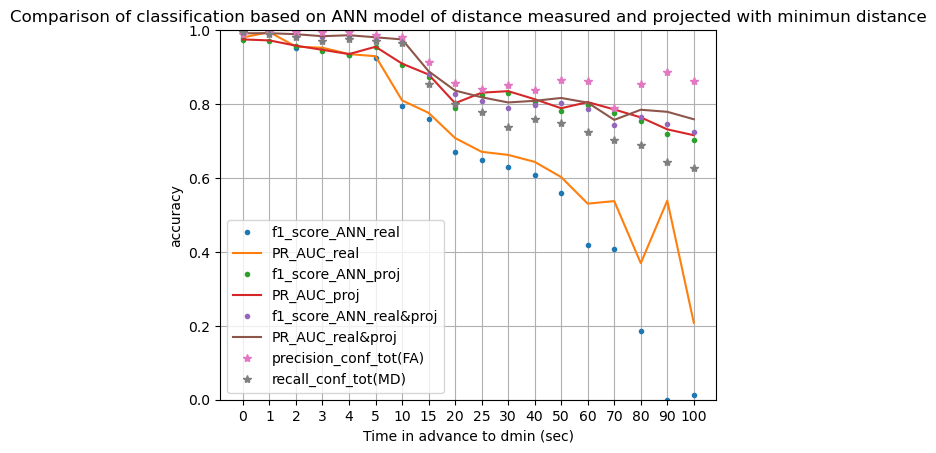

In [31]:
#the following picture compares the classification scores for the different models
m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)

ax.plot(m1, f1_score_ANN_real, '.', label='f1_score_ANN_real')
ax.plot(m1, pr_auc_real, '-', label='PR_AUC_real')
ax.plot(m1, f1_score_ANN_proj, '.', label='f1_score_ANN_proj')
ax.plot(m1, pr_auc_proj, '-', label='PR_AUC_proj')
ax.plot(m1, f1_score_ANN_tot, '.', label='f1_score_ANN_real&proj')
ax.plot(m1, pr_auc_tot, '-', label='PR_AUC_real&proj')
ax.plot(m1, precision_conf_tot, '*', label='precision_conf_tot(FA)')
ax.plot(m1, recall_conf_tot, '*', label='recall_conf_tot(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Comparison of classification based on ANN model of distance measured and projected with minimun distance')
ax.legend()

# <span style="color:yellow"> Other previous pieces of code

In [ ]:
import numpy as np
red=0
MARGEN_CHOQUE=50 #if MARGEN_CHOQUE>200, the classification would be balanced and the predicition would work very well
df_dmin['Collision']=np.where(df_dmin['dmin']<=MARGEN_CHOQUE,1,0)

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

k_real=[]
k_proj=[]
k_tot=[]
jaccard_score_SVM_real=[]
f1_score_SVM_real=[]
accuracy_SVM_real=[]
confusion_SVM_real=[]
classif_report_SVM_real=[]
precision_conf_real=[]
recall_conf_real=[]
precisionPR_real=[]
recallPR_real=[]
pr_auc_real=[]

jaccard_score_SVM_proj=[]
f1_score_SVM_proj=[]
accuracy_SVM_proj=[]
confusion_SVM_proj=[]
classif_report_SVM_proj=[]
precision_conf_proj=[]
recall_conf_proj=[]
precisionPR_proj=[]
recallPR_proj=[]
pr_auc_proj=[]

jaccard_score_SVM_tot=[]
f1_score_SVM_tot=[]
accuracy_SVM_tot=[]
confusion_SVM_tot=[]
classif_report_SVM_tot=[]
precision_conf_tot=[]
recall_conf_tot=[]
precisionPR_tot=[]
recallPR_tot=[]
pr_auc_tot=[]

Ks=np.zeros((len(dmin_cols)),dtype=int)
Ksp=np.zeros((len(dmin_cols)),dtype=int)
Kst=np.zeros((len(dmin_cols)),dtype=int)

#Ks=np.zeros(range(len(dmin_cols)-red))

import warnings
warnings.filterwarnings('ignore')

dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
for i in range(len(dmin_cols)-red):
    dmin_cols_prev=dmin_cols.copy()
    del dmin_cols_prev[0:i]
    
    df1=df_dmin[dmin_cols_prev]
    df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dreal_ev2=pd.concat([df2, df1], axis=1)
    
    dreal_ev2b = dreal_ev2.dropna()
    
    Xreal=dreal_ev2b[dmin_cols_prev].values
    yreal=dreal_ev2b['Collision'].values
    
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    #Xreal = preprocessing.StandardScaler().fit(Xreal).transform(Xreal.astype(float))
    
    Xreal_train, Xreal_test, yreal_train, yreal_test = train_test_split( Xreal, yreal, test_size=0.2, random_state=4)
    
    import numpy as np
    Ks[i] = 21
    f1_acc = np.zeros((Ks[i]-1))
    k_acc = np.zeros((Ks[i]-1))

    for n in range(1,Ks[i]):
        pond = n*0.99/20
        weights = {0: pond, 1: 1-pond}
        SVM_real = svm.SVC(kernel='linear',class_weight=weights).fit(Xreal_train,yreal_train)
        ypred_test = SVM_real.predict(Xreal_test)
        f1_acc[n-1]=f1_score(yreal_test , ypred_test, pos_label=1, average='binary')
        k_acc[n-1]=n
    f1_max=f1_acc.max(axis=0)        

    k = (f1_acc.argmax(axis=0)+1)*0.99/20
    #print(k)
    k_real.append(k)
     
    #Train Model and Predict  
    weights = {0: k, 1: 1-k}
    SVM_real = svm.SVC(kernel='linear',class_weight=weights).fit(Xreal_train,yreal_train)
    ypred_test = SVM_real.predict(Xreal_test)
    
    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_SVM_real.append(jaccard_score(yreal_test , ypred_test))
    f1_score_SVM_real.append(f1_score(yreal_test , ypred_test, pos_label=1, average='binary'))
    accuracy_SVM_real.append(accuracy_score(yreal_test , ypred_test))
    conf=confusion_matrix(yreal_test , ypred_test)
    confusion_SVM_real.append(conf)
    classif_report_SVM_real.append(classification_report(yreal_test , ypred_test))
    precision_conf_real.append(conf[1][1]/(conf[1][1]+conf[0][1]))
    recall_conf_real.append(conf[1][1]/(conf[1][1]+conf[1][0]))
    precisionPR_real1, recallPR_real1, _ = precision_recall_curve(yreal_test , ypred_test)
    precisionPR_real.append(precisionPR_real1)
    recallPR_real.append(recallPR_real1)
    pr_auc_real.append(auc(recallPR_real1,precisionPR_real1))
    
    
    #We repeat the same steps with the projected distance
    dproj_cols = [col for col in df_dmin if 'dproj_t_dmin' in col]
    dproj_cols_prev=dproj_cols.copy()
    del dproj_cols_prev[0:i]
    
    df11=df_dmin[dproj_cols_prev]
    df21=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dproj_ev2=pd.concat([df21, df11], axis=1)

    dproj_ev2b = dproj_ev2.dropna()

    Xproj=dproj_ev2b[dproj_cols_prev].values
    yproj=dproj_ev2b['Collision'].values

        
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    #Xproj = preprocessing.StandardScaler().fit(Xproj).transform(Xproj.astype(float))
    
    Xproj_train, Xproj_test, yproj_train, yproj_test = train_test_split( Xproj, yproj, test_size=0.2, random_state=4)
    
    
    import numpy as np
    Ksp[i] = 21
    f1_accp = np.zeros((Ksp[i]-1))
    kp_acc = np.zeros((Ksp[i]-1))

    for np in range(1,Ksp[i]):
        pond_p = np*0.99/20
        weights = {0: pond_p, 1: 1-pond_p}
        SVM_proj = svm.SVC(kernel='linear',class_weight=weights).fit(Xproj_train,yproj_train)
        ypred_proj_test = SVM_proj.predict(Xproj_test)
        f1_accp[np-1]=f1_score(yproj_test , ypred_proj_test, pos_label=1, average='binary')
        kp_acc[np-1]=np
    f1_maxp=f1_accp.max(axis=0)        


    kp = (f1_accp.argmax(axis=0)+1)*0.99/(20)
    #print(kp)
    k_proj.append(kp)
     
    #Train Model and Predict  
    weights = {0: kp, 1: 1-kp}
    SVM_proj = svm.SVC(kernel='linear',class_weight=weights).fit(Xproj_train,yproj_train)
    ypred_proj_test = SVM_proj.predict(Xproj_test)

    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_SVM_proj.append(jaccard_score(yproj_test , ypred_proj_test))
    f1_score_SVM_proj.append(f1_score(yproj_test , ypred_proj_test, pos_label=1, average='binary'))
    accuracy_SVM_proj.append(accuracy_score(yproj_test , ypred_proj_test))
    conf_proj=confusion_matrix(yproj_test , ypred_proj_test)
    confusion_SVM_proj.append(conf_proj)
    classif_report_SVM_proj.append(classification_report(yproj_test , ypred_proj_test))
    precision_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[0][1]))
    recall_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[1][0]))
    precisionPR_proj1, recallPR_proj1, _ = precision_recall_curve(yproj_test , ypred_proj_test)
    precisionPR_proj.append(precisionPR_proj1)
    recallPR_proj.append(recallPR_proj1)
    pr_auc_proj.append(auc(recallPR_proj1,precisionPR_proj1))

    
    #Finally, we repeat the same steps with the real and projected distance
    dtot_cols = [col for col in df_dmin if 'dreal_t_dmin' in col or 'dproj_t_dmin' in col]
    dtot_cols_prev=dtot_cols.copy()
    del dtot_cols_prev[0:2*i]
    
    df1t=df_dmin[dtot_cols_prev]
    df2t=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dtot_ev2=pd.concat([df2t, df1t], axis=1)

    dtot_ev2b = dtot_ev2.dropna()

    Xtot=dtot_ev2b[dtot_cols_prev].values
    ytot=dtot_ev2b['Collision'].values
        
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    #Xtot = preprocessing.StandardScaler().fit(Xtot).transform(Xtot.astype(float))
    
    Xtot_train, Xtot_test, ytot_train, ytot_test = train_test_split( Xtot, ytot, test_size=0.2, random_state=4)
    
    import numpy as np
    Kst[i] = 21
    f1_acct = np.zeros((Kst[i]-1))
    k_acct = np.zeros((Kst[i]-1))

    for np in range(1,Kst[i]):
        pond_p = np*0.99/20
        weights = {0: pond_p, 1: 1-pond_p}
        SVM_tot = svm.SVC(kernel='linear',class_weight=weights).fit(Xtot_train,ytot_train)
        ypred_tot_test = SVM_tot.predict(Xtot_test)
        f1_acct[np-1]=f1_score(ytot_test , ypred_tot_test, pos_label=1, average='binary')
        k_acct[np-1]=np
    f1_maxt=f1_acct.max(axis=0)        

    kt = (f1_acct.argmax(axis=0)+1)*0.99/(20)
    #print(kt)
    k_proj.append(kt)
     
    #Train Model and Predict  
    weights = {0: kt, 1: 1-kt}
    SVM_tot = svm.SVC(kernel='linear',class_weight=weights).fit(Xtot_train,ytot_train)
    ypred_tot_test = SVM_tot.predict(Xtot_test)


    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_SVM_tot.append(jaccard_score(ytot_test , ypred_tot_test))
    f1_score_SVM_tot.append(f1_score(ytot_test , ypred_tot_test, pos_label=1, average='binary'))
    accuracy_SVM_tot.append(accuracy_score(ytot_test , ypred_tot_test))
    conf_tot=confusion_matrix(ytot_test , ypred_tot_test)
    confusion_SVM_tot.append(conf_tot)
    classif_report_SVM_tot.append(classification_report(ytot_test , ypred_tot_test))
    precision_conf_tot.append(conf_tot[1][1]/(conf_tot[1][1]+conf_tot[0][1]))
    recall_conf_tot.append(conf_tot[1][1]/(conf_tot[1][1]+conf_tot[1][0]))
    precisionPR_tot1, recallPR_tot1, _ = precision_recall_curve(ytot_test , ypred_tot_test)
    precisionPR_tot.append(precisionPR_tot1)
    recallPR_tot.append(recallPR_tot1)
    pr_auc_tot.append(auc(recallPR_tot1,precisionPR_tot1))        
    
    
    print(dmin_cols_prev[0])
    print(k)
    print(dproj_cols_prev[0])
    print(kp)
    print('dmin&dproj')
    print(kt)

dreal_t_dmin-0
0.495
dproj_t_dmin-0
0.3465
dmin&dproj
0.396
dreal_t_dmin-1
0.3465
dproj_t_dmin-1
0.297
dmin&dproj
0.594
dreal_t_dmin-2
0.4455
dproj_t_dmin-2
0.396
dmin&dproj
0.198
dreal_t_dmin-3
0.396
dproj_t_dmin-3
0.3465
dmin&dproj
0.198
dreal_t_dmin-4
0.495
dproj_t_dmin-4
0.3465
dmin&dproj
0.3465


In [ ]:
f1_acc

In [35]:
k_real

[1, 8, 9, 1, 1, 1, 1, 3, 1, 5, 6, 7, 7, 5, 1, 1, 3, 1]

In [36]:
f1_accp

array([0.77968098, 0.7514713 , 0.83828125, 0.82727003, 0.8365182 ,
       0.80918561, 0.84279802, 0.82276011, 0.84010943])

In [37]:
k_proj

[5, 4, 3, 3, 3, 3, 9, 4, 5, 5, 4, 3, 3, 9, 9, 9, 9, 7]

In [38]:
f1_acct

array([0.81292066, 0.83493225, 0.84643205, 0.83493225, 0.8295996 ,
       0.82954019, 0.8295996 , 0.82933659, 0.82256626])

In [39]:
k_tot

[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 2, 3, 3]

Text(0.5, 1.0, 'Scoring for different K')

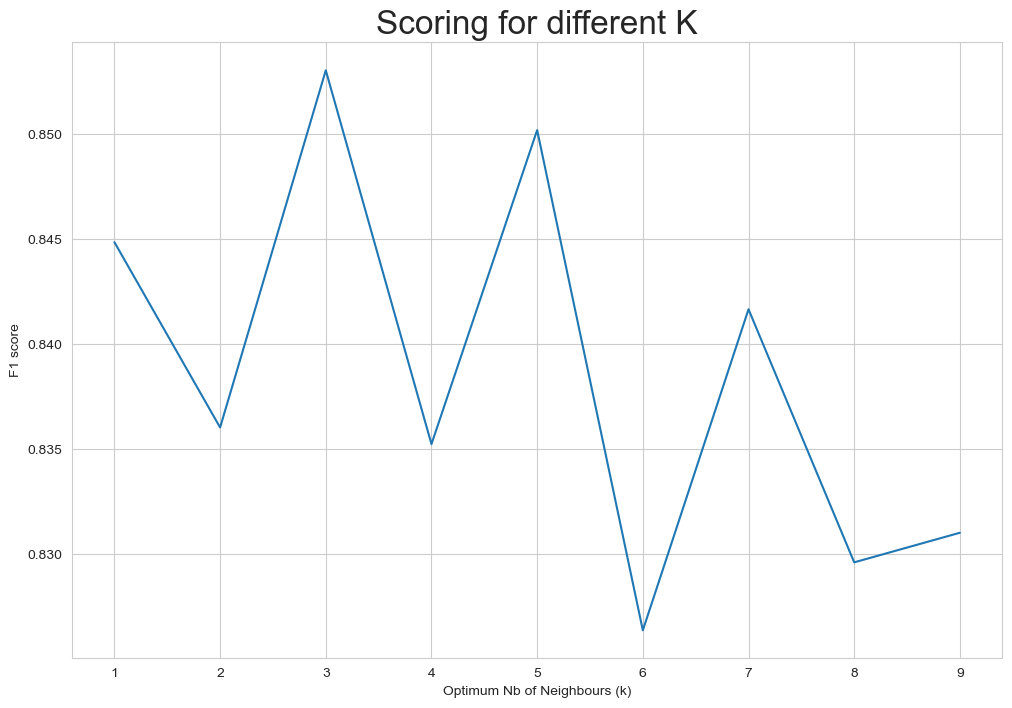

In [60]:
#Representación de cómo varía la exactitud (f1_score) con la K de la KNN

import numpy as np
red=0
MARGEN_CHOQUE=50 #if MARGEN_CHOQUE>200, the classification would be balanced and the predicition would work very well
df_dmin['Collision']=np.where(df_dmin['dmin']<=MARGEN_CHOQUE,1,0)

k_real1=[]

i=7
dmin_cols = [col for col in df_dmin if 'dreal_t_dmin' in col]
dmin_cols_prev=dmin_cols.copy()
Ks=np.zeros((len(dmin_cols)),dtype=int)
del dmin_cols_prev[0:i]
    
df1=df_dmin[dmin_cols_prev]
df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
dreal_ev2=pd.concat([df2, df1], axis=1)
    
dreal_ev2b = dreal_ev2.dropna()
    
Xreal=dreal_ev2b[dmin_cols_prev].values
yreal=dreal_ev2b['Collision'].values

#Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
Xreal = preprocessing.StandardScaler().fit(Xreal).transform(Xreal.astype(float))
    
Xreal_train, Xreal_test, yreal_train, yreal_test = train_test_split( Xreal, yreal, test_size=0.2, random_state=4)

Ks[i] = 10
f1_acc1 = np.zeros((Ks[i]-1))
k_acc1 = np.zeros((Ks[i]-1))

for n in range(1,Ks[i]):
    knn_real1 = KNeighborsClassifier(n_neighbors = n).fit(Xreal_train,yreal_train)
    ypred_test = knn_real1.predict(Xreal_test)
    f1_acc1[n-1]=f1_score(yreal_test , ypred_test, average='macro')
    k_acc1[n-1]=n
f1_max=f1_acc1.max(axis=0)        


k = f1_acc1.argmax(axis=0)+1
#print(k)
k_real1.append(k)

import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(12,8))

sns.lineplot(k_acc1, f1_acc1)

plt.xlabel('Optimum Nb of Neighbours (k)')
plt.ylabel('F1 score')
plt.xticks(k_acc1)
plt.title('Scoring for different K', fontsize=24)

In [55]:
k_real1

[1]

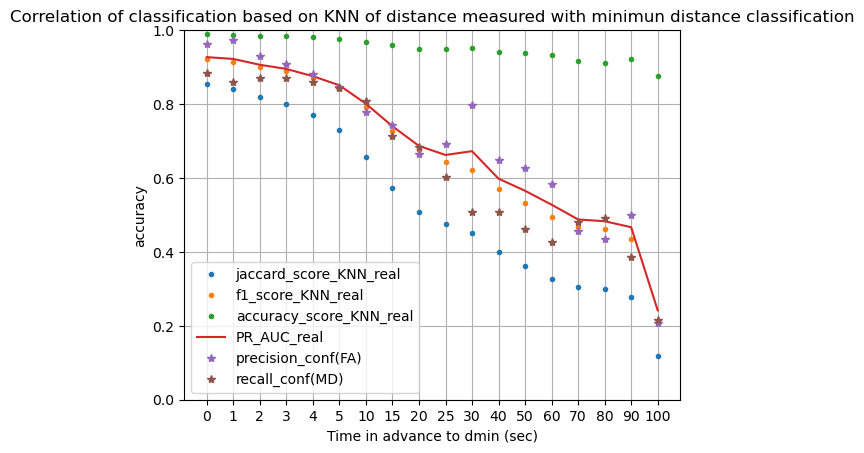

In [40]:
#the following picture shows how the classification scores decreases with time for distance measured and projected
m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_KNN_real, '.', label='jaccard_score_KNN_real')
ax.plot(m1, f1_score_KNN_real, '.', label='f1_score_KNN_real')
ax.plot(m1, accuracy_KNN_real, '.', label='accuracy_score_KNN_real')

ax.plot(m1, pr_auc_real, '-', label='PR_AUC_real')
ax.plot(m1, precision_conf_real, '*', label='precision_conf(FA)')
ax.plot(m1, recall_conf_real, '*', label='recall_conf(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Correlation of classification based on KNN of distance measured with minimun distance classification')
ax.legend()

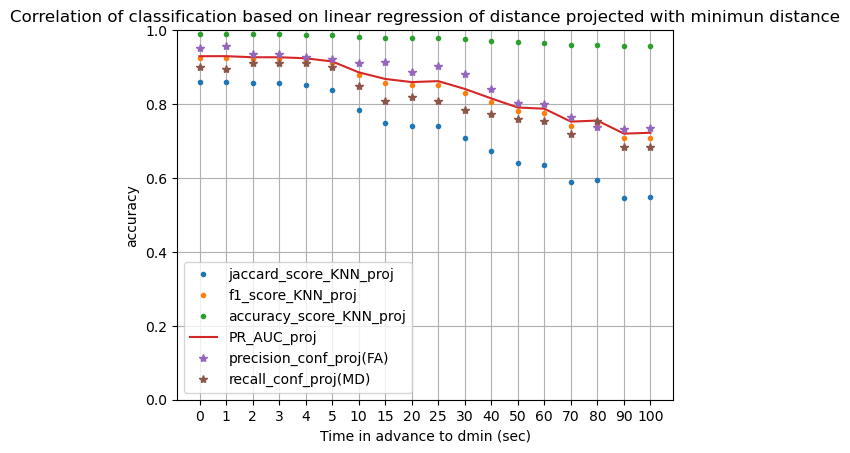

In [41]:
#the following picture shows how the classification scores decreases with time for distance measured and projected
m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_KNN_proj, '.', label='jaccard_score_KNN_proj')
ax.plot(m1, f1_score_KNN_proj, '.', label='f1_score_KNN_proj')
ax.plot(m1, accuracy_KNN_proj, '.', label='accuracy_score_KNN_proj')

ax.plot(m1, pr_auc_proj, '-', label='PR_AUC_proj')
ax.plot(m1, precision_conf_proj, '*', label='precision_conf_proj(FA)')
ax.plot(m1, recall_conf_proj, '*', label='recall_conf_proj(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Correlation of classification based on linear regression of distance projected with minimun distance')
ax.legend()

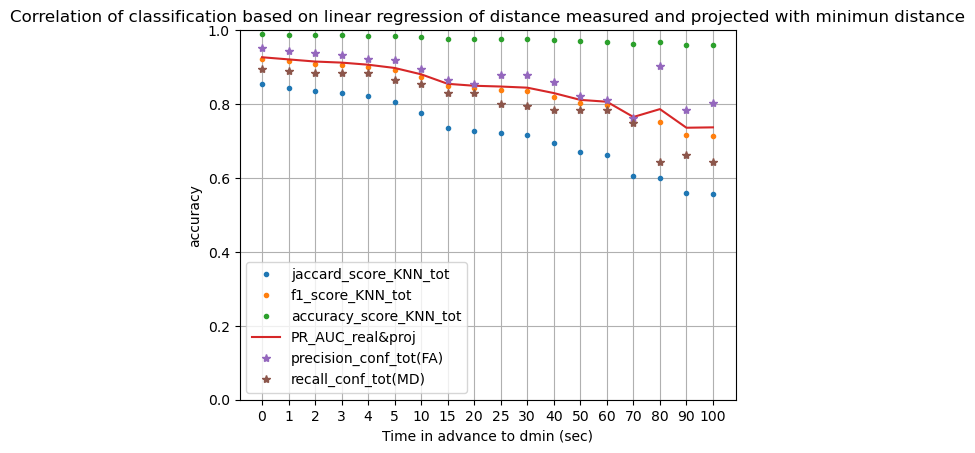

In [42]:
#the following picture shows how the classification scores decreases with time for distance measured and projected
m1=m.copy()
del m1[len(m)-red:len(m)]

fig, ax = plt.subplots()
plt.ylim(0, 1)
plt.grid(b=True)
ax.plot(m1, jaccard_score_KNN_tot, '.', label='jaccard_score_KNN_tot')
ax.plot(m1, f1_score_KNN_tot, '.', label='f1_score_KNN_tot')
ax.plot(m1, accuracy_KNN_tot, '.', label='accuracy_score_KNN_tot')

ax.plot(m1, pr_auc_tot, '-', label='PR_AUC_real&proj')
ax.plot(m1, precision_conf_tot, '*', label='precision_conf_tot(FA)')
ax.plot(m1, recall_conf_tot, '*', label='recall_conf_tot(MD)')
ax.set_xlabel('Time in advance to dmin (sec)')
ax.set_ylabel('accuracy')
ax.set_title('Correlation of classification based on linear regression of distance measured and projected with minimun distance')
ax.legend()

#PRUEBA YA NO SIRVE
    dmin_cols_prev=dmin_cols.copy()

    del dmin_cols_prev[0:5]
    
    df1=df_dmin[dmin_cols_prev]
    df2=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dreal_ev2=pd.concat([df2, df1], axis=1)
    
    dreal_ev2b = dreal_ev2.dropna()
    
    Xreal=dreal_ev2b[dmin_cols_prev].values
    yreal=dreal_ev2b['Collision'].values
    
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    Xreal = preprocessing.StandardScaler().fit(Xreal).transform(Xreal.astype(float))
    
    Xreal_train, Xreal_test, yreal_train, yreal_test = train_test_split( Xreal, yreal, test_size=0.2, random_state=4)
    
    Ks = 10
    f1_acc = np.zeros((Ks-1))
    k_acc = np.zeros((Ks-1))

    for n in range(1,Ks):
        knn_real = KNeighborsClassifier(n_neighbors = n).fit(Xreal_train,yreal_train)
        ypred_test = knn_real.predict(Xreal_test)
        f1_acc[n-1]=f1_score(yreal_test , ypred_test, average='macro')
        k_acc[n-1]=n
    f1_max=f1_acc.max(axis=0)        
    print(f1_acc)
    print(f1_max)

    k = f1_acc.argmax(axis=0)+1
    print(k)
    #Train Model and Predict  
    knn_real = KNeighborsClassifier(n_neighbors = k).fit(Xreal_train,yreal_train)
    ypred_test = knn_real.predict(Xreal_test)
    
    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_KNN_real.append(jaccard_score(yreal_test , ypred_test))
    f1_score_KNN_real.append(f1_score(yreal_test , ypred_test, average='macro'))
    accuracy_KNN_real.append(accuracy_score(yreal_test , ypred_test))
    conf=confusion_matrix(yreal_test , ypred_test)
    confusion_KNN_real.append(conf)
    classif_report_KNN_real.append(classification_report(yreal_test , ypred_test))
    precision_conf_real.append(conf[1][1]/(conf[1][1]+conf[0][1]))
    recall_conf_real.append(conf[1][1]/(conf[1][1]+conf[1][0]))    


    dproj_cols = [col for col in df_dmin if 'dproj_t_dmin' in col]
    dproj_cols_prev=dproj_cols.copy()
    del dproj_cols_prev[0:5]
    

    df11=df_dmin[dproj_cols_prev]
    df21=df_dmin[['avo1_ID_num','avo2_ID_num','ind_tº_dmin','dmin','Collision']]
    dproj_ev2=pd.concat([df21, df11], axis=1)

    dproj_ev2b = dproj_ev2.dropna()

    Xproj=dproj_ev2b[dproj_cols_prev].values
    yproj=dproj_ev2b['Collision'].values

        
    #Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:
    Xproj = preprocessing.StandardScaler().fit(Xproj).transform(Xproj.astype(float))
    
    Xproj_train, Xproj_test, yproj_train, yproj_test = train_test_split( Xproj, yproj, test_size=0.2, random_state=4)
    
    Ksp = 10
    f1_accp = np.zeros((Ksp-1))
    kp_acc = np.zeros((Ksp-1))

    
    for np in range(1,Ksp):
        knn_proj = KNeighborsClassifier(n_neighbors = np).fit(Xproj_train,yproj_train)
        ypred_proj_test = knn_proj.predict(Xproj_test)
        f1_accp[np-1]=f1_score(yproj_test , ypred_proj_test, average='macro')
        kp_acc[np-1]=np
    f1_maxp=f1_accp.max(axis=0)        
    print(f1_accp)
    print(f1_maxp)

    kp = f1_accp.argmax(axis=0)+1
    print(kp)
    k_proj.append(kp)
    
    #Train Model and Predict  
    knn_proj = KNeighborsClassifier(n_neighbors = kp).fit(Xproj_train,yproj_train)
    ypred_proj_test = knn_proj.predict(Xproj_test)

    #and evaluate the accuracy of the classification of the predicted distances
    jaccard_score_KNN_proj.append(jaccard_score(yproj_test , ypred_proj_test))
    f1_score_KNN_proj.append(f1_score(yproj_test , ypred_proj_test, average='macro'))
    accuracy_KNN_proj.append(accuracy_score(yproj_test , ypred_proj_test))
    conf_proj=confusion_matrix(yproj_test , ypred_proj_test)
    confusion_KNN_proj.append(conf_proj)
    classif_report_KNN_proj.append(classification_report(yproj_test , ypred_proj_test))
    precision_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[0][1]))
    recall_conf_proj.append(conf_proj[1][1]/(conf_proj[1][1]+conf_proj[1][0]))

In [43]:
df_conf_KNN=pd.DataFrame()
df_conf_KNN['conf_real']=confusion_KNN_real
df_conf_KNN['conf_proj']=confusion_KNN_proj
df_conf_KNN['conf_real&proj']=confusion_KNN_tot
df_conf_KNN

,conf_real,conf_proj,conf_real&proj
0,"[[2031, 6], [20, 151]]","[[2029, 8], [17, 154]]","[[2029, 8], [18, 153]]"
1,"[[2033, 4], [24, 147]]","[[2030, 7], [18, 153]]","[[2028, 9], [19, 152]]"
2,"[[2026, 11], [22, 149]]","[[2026, 11], [15, 156]]","[[2027, 10], [20, 151]]"
3,"[[2022, 15], [22, 149]]","[[2026, 11], [15, 156]]","[[2026, 11], [20, 151]]"
4,"[[2017, 20], [24, 147]]","[[2025, 12], [15, 156]]","[[2024, 13], [20, 151]]"
5,"[[2011, 26], [27, 144]]","[[2024, 13], [17, 154]]","[[2024, 13], [23, 148]]"
6,"[[1998, 39], [33, 138]]","[[2023, 14], [26, 145]]","[[2020, 17], [25, 146]]"
7,"[[1995, 42], [49, 122]]","[[2024, 13], [33, 138]]","[[2015, 22], [29, 142]]"
8,"[[1978, 59], [54, 117]]","[[2019, 18], [31, 140]]","[[2013, 24], [29, 142]]"
9,"[[1991, 46], [68, 103]]","[[2022, 15], [33, 138]]","[[2018, 19], [34, 137]]"


In [44]:
confusion_KNN_real

[array([[2031,    6],
        [  20,  151]], dtype=int64),
 array([[2033,    4],
        [  24,  147]], dtype=int64),
 array([[2026,   11],
        [  22,  149]], dtype=int64),
 array([[2022,   15],
        [  22,  149]], dtype=int64),
 array([[2017,   20],
        [  24,  147]], dtype=int64),
 array([[2011,   26],
        [  27,  144]], dtype=int64),
 array([[1998,   39],
        [  33,  138]], dtype=int64),
 array([[1995,   42],
        [  49,  122]], dtype=int64),
 array([[1978,   59],
        [  54,  117]], dtype=int64),
 array([[1991,   46],
        [  68,  103]], dtype=int64),
 array([[2015,   22],
        [  84,   87]], dtype=int64),
 array([[1990,   47],
        [  84,   87]], dtype=int64),
 array([[1990,   47],
        [  92,   79]], dtype=int64),
 array([[1985,   52],
        [  98,   73]], dtype=int64),
 array([[1939,   98],
        [  89,   82]], dtype=int64),
 array([[1928,  109],
        [  87,   84]], dtype=int64),
 array([[1971,   66],
        [ 105,   66]], dtype=int64

In [45]:
confusion_KNN_proj

[array([[2029,    8],
        [  17,  154]], dtype=int64),
 array([[2030,    7],
        [  18,  153]], dtype=int64),
 array([[2026,   11],
        [  15,  156]], dtype=int64),
 array([[2026,   11],
        [  15,  156]], dtype=int64),
 array([[2025,   12],
        [  15,  156]], dtype=int64),
 array([[2024,   13],
        [  17,  154]], dtype=int64),
 array([[2023,   14],
        [  26,  145]], dtype=int64),
 array([[2024,   13],
        [  33,  138]], dtype=int64),
 array([[2019,   18],
        [  31,  140]], dtype=int64),
 array([[2022,   15],
        [  33,  138]], dtype=int64),
 array([[2019,   18],
        [  37,  134]], dtype=int64),
 array([[2012,   25],
        [  39,  132]], dtype=int64),
 array([[2005,   32],
        [  41,  130]], dtype=int64),
 array([[2005,   32],
        [  42,  129]], dtype=int64),
 array([[1999,   38],
        [  48,  123]], dtype=int64),
 array([[1991,   46],
        [  42,  129]], dtype=int64),
 array([[1994,   43],
        [  54,  117]], dtype=int64

In [46]:
confusion_KNN_tot

[array([[2029,    8],
        [  18,  153]], dtype=int64),
 array([[2028,    9],
        [  19,  152]], dtype=int64),
 array([[2027,   10],
        [  20,  151]], dtype=int64),
 array([[2026,   11],
        [  20,  151]], dtype=int64),
 array([[2024,   13],
        [  20,  151]], dtype=int64),
 array([[2024,   13],
        [  23,  148]], dtype=int64),
 array([[2020,   17],
        [  25,  146]], dtype=int64),
 array([[2015,   22],
        [  29,  142]], dtype=int64),
 array([[2013,   24],
        [  29,  142]], dtype=int64),
 array([[2018,   19],
        [  34,  137]], dtype=int64),
 array([[2018,   19],
        [  35,  136]], dtype=int64),
 array([[2015,   22],
        [  37,  134]], dtype=int64),
 array([[2008,   29],
        [  37,  134]], dtype=int64),
 array([[2006,   31],
        [  37,  134]], dtype=int64),
 array([[1997,   40],
        [  43,  128]], dtype=int64),
 array([[2025,   12],
        [  61,  110]], dtype=int64),
 array([[2006,   31],
        [  58,  113]], dtype=int64

Confusion matrix, without normalization
[[1998   39]
 [  33  138]]


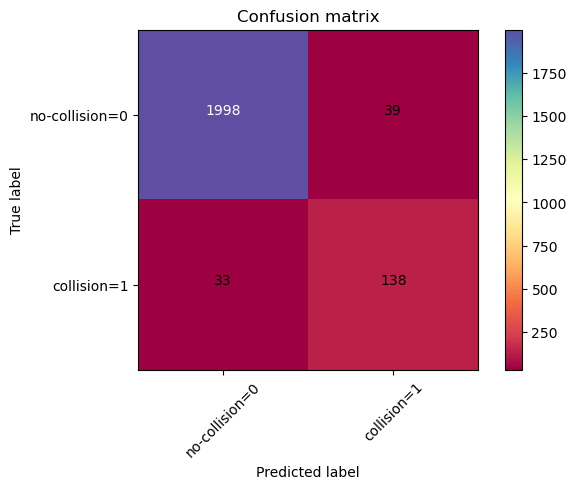

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import ConfusionMatrixDisplay
plt.figure()
#ConfusionMatrixDisplay(confusion_MLR_real[5],display_labels=[1,0])
plot_confusion_matrix(confusion_KNN_real[6], classes=['no-collision=0','collision=1'],normalize= False,  title='Confusion matrix')

In [45]:
print(classif_report_KNN_real[5])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2169
           1       0.87      0.83      0.85       169

    accuracy                           0.98      2338
   macro avg       0.93      0.91      0.92      2338
weighted avg       0.98      0.98      0.98      2338



In [46]:
print(classif_report_KNN_proj[5])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2169
           1       0.93      0.86      0.89       169

    accuracy                           0.99      2338
   macro avg       0.96      0.93      0.94      2338
weighted avg       0.98      0.99      0.98      2338



# Second Conclusion

### <span style="color:blue">Considering Linear Regressions, the prediction based on the previous distances performs better than the prediction based on the projected minimum distances, up to 40 seconds before the minimum distance timespot. From that time onwards, the Regression based on previous projected distances performs slightly better than the one based on real distances.
</span> 

### The predicted minimum distance is quite accurate till 15 seconds before the minimum distance timespot and reasonably accurate till 25 seconds in advance.
### <span style="color:blue">The correlation of the projected minimum distance at each time in advance always performs worse than the multiple linear Regressions of distances' measured and projected. In fact, the prediction based on the projected distance at time t_dmin- T is worse than the average distance as a prediction from 60 seconds in advance.

In [268]:
test_y_dproj_ti.transpose().shape

(1210,)

In [265]:
test_y_dproj.transpose()

array([[676.79607179,   1.28900808, 154.11739517, ...,  28.76656812,
         46.96910594, 629.54592221]])

In [262]:
test_y_dproj_ti.transpose()

array([6.76792167e+02, 4.23950588e-09, 1.53856517e+02, ...,
       2.87554030e+01, 4.67851312e+01, 6.29510165e+02])

In [279]:
type(test_y_dproj)

numpy.ndarray

In [354]:
#Function to calculate Rsquare
dfkk=pd.concat((pd.Series(test_y_dproj[:,0]),pd.Series(test_y_dproj_ti)), keys=["test_dmin_real", "test_dmin_dproj_ti"],axis=1)
dfkk['dmin_real-dmin_proj_ti']= dfkk.apply(lambda row: (row.test_dmin_real - row.test_dmin_dproj_ti)**2, axis = 1)
dmin_real_avg=dfkk.loc[:, 'test_dmin_real'].mean()
dfkk['dmin_real-dmin_avg']= dfkk.apply(lambda row: (row.test_dmin_real - dmin_real_avg)**2, axis = 1)
dfkk.head()
Rsq=1-(dfkk.loc[:, 'dmin_real-dmin_proj_ti'].sum())/(dfkk.loc[:, 'dmin_real-dmin_avg'].sum())
Rsq

0.8527585662461805

In [331]:
aa=pd.Series(test_y_dproj[:,0])

In [317]:
test_y_dproj[:,0].shape

(1245,)

In [ ]:
0.8419418469357207

In [371]:
red=7
m1=m.copy()
del m1[-red:]
m1

['0', '1', '2', '3', '4', '5', '10', '15', '20', '25', '30']

In [11]:
rep=pd.DataFrame([[0,1,5],[0,2,4],[0,1,7],[1,66,4],[1,66,3]], columns=['A1','A2','dist'])
rep

,A1,A2,dist
0,0,1,5
1,0,2,4
2,0,1,7
3,1,66,4
4,1,66,3


In [67]:
my=rep[rep.duplicated(subset=['A1','A2'])]
my

,A1,A2,dist
2,0,1,7
4,1,66,3


In [68]:
my2=rep[rep[['A1','A2']].duplicated(keep=False)]
my2

,A1,A2,dist
0,0,1,5
2,0,1,7
3,1,66,4
4,1,66,3


In [69]:
idxmin = my2.groupby(['A1', 'A2'])['dist'].idxmax()
idxmin

A1  A2
0   1     2
1   66    3
Name: dist, dtype: int64

In [125]:
rep1=rep.copy()
rep1.drop(index=rep.iloc[list(idxmin),:].index.tolist(), inplace=True)
rep1

,A1,A2,dist
0,0,1,5
1,0,2,4
4,1,66,3


In [13]:
rep['dist']=rep['dist']+25

In [14]:
rep

,A1,A2,dist
0,0,1,30
1,0,2,29
2,0,1,32
3,1,66,29
4,1,66,28
